In [27]:
import re
from pathlib import Path
from itertools import combinations
import numpy as np
import pandas as pd
import pyrepseq as prs
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
# Setting paths
data_dir_kb = Path("../Data/20250910 Comparison 2/Kb")
data_dir_kd = Path("../Data/20250910 Comparison 2/Kd")
output_dir = Path("Comparison2_Merged_Heatmaps")
output_dir.mkdir(exist_ok=True)

In [29]:
# Define sample files for Kb (178.3 and B10BR strains)
kb_samples = {
    # 178.3 strain (donor naive)
    "1783 Naive LL": data_dir_kb / "20250910 1783 Naive LL TCR Repertoire.csv",
    "1783 Naive SLO": data_dir_kb / "20250910 1783 Naive SLO TCR Repertoire.csv",
    
    # B10BR strain - Naive (recipient naive)
    "B10BR NaiveA LL": data_dir_kb / "20250910 B10BR NaiveA LL TCR Repertoire.csv",
    "B10BR NaiveA SLO": data_dir_kb / "20250910 B10BR NaiveA SLO TCR Repertoire.csv",
    "B10BR NaiveB LL": data_dir_kb / "20250910 B10BR NaiveB LL TCR Repertoire.csv",
    "B10BR NaiveB SLO": data_dir_kb / "20250910 B10BR NaiveB SLO TCR Repertoire.csv",
    
    # B10BR strain - PD1hi
    "B10BR PD1hiA LL": data_dir_kb / "20250910 B10BR PD1hiA LL TCR Repertoire.csv",
    "B10BR PD1hiB LL": data_dir_kb / "20250910 B10BR PD1hiB LL TCR Repertoire.csv",
    "B10BR PD1hiC LL": data_dir_kb / "20250910 B10BR PD1hiC LL TCR Repertoire.csv",
    "B10BR PD1hiD LL": data_dir_kb / "20250910 B10BR PD1hiD LL TCR Repertoire.csv",
    "B10BR PD1hiE LL": data_dir_kb / "20250910 B10BR PD1hiE LL TCR Repertoire.csv",
}

# Define sample files for Kd (B6Kd and C57BL6 strains)
kd_samples = {
    # B6Kd strain (donor naive)
    "B6Kd Naive LL": data_dir_kd / "20250910 B6Kd Naive LL TCR Repertoire.csv",
    "B6Kd Naive SLO": data_dir_kd / "20250910 B6Kd Naive SLO TCR Repertoire.csv",
    
    # C57BL6/BL6 strain - Naive (recipient naive)
    "BL6 NaiveA LL": data_dir_kd / "20250910 BL6 NaiveA LL TCR Repertoire.csv",
    "BL6 NaiveA SLO": data_dir_kd / "20250910 BL6 NaiveA SLO TCR Repertoire.csv",
    "BL6 NaiveB LL": data_dir_kd / "20250910 BL6 NaiveB LL TCR Repertoire.csv",
    "BL6 NaiveB SLO": data_dir_kd / "20250910 BL6 NaiveB SLO TCR Repertoire.csv",
    
    # C57BL6/BL6 strain - PD1hi
    "BL6 PD1hiA LL": data_dir_kd / "20251120 BL6 PD1hiA LL TCR Repertoire.csv",
    "BL6 PD1hiB LL": data_dir_kd / "20251120 BL6 PD1hiB LL TCR Repertoire.csv",
    "BL6 PD1hiC LL": data_dir_kd / "20251120 BL6 PD1hiC LL TCR Repertoire.csv",
}

In [30]:
def parse_sample_name(sample_name):
    """Parse sample name to extract metadata."""
    # Normalize strain names
    if sample_name.startswith("178.3") or sample_name.startswith("1783"):
        strain = "178.3"
    elif sample_name.startswith("B10BR"):
        strain = "B10BR"
    elif sample_name.startswith("B6Kd"):
        strain = "B6Kd"
    elif sample_name.startswith("BL6") or sample_name.startswith("C57BL6"):
        strain = "C57BL6"
    else:
        strain = "Unknown"
    
    # Determine TCR type
    if "PD1hi" in sample_name:
        tcr_type = "PD1hi"
    elif "PD1neg" in sample_name:
        tcr_type = "PD1neg"
    elif "Naive" in sample_name:
        tcr_type = "Naive"
    elif "Pre-immune" in sample_name or "pre-immune" in sample_name:
        tcr_type = "Pre-immune"
    else:
        tcr_type = "Unknown"
    
    # Determine origin
    if " LL " in sample_name or sample_name.endswith(" LL") or "_LL" in sample_name:
        origin = "LL"
    elif "SLO" in sample_name:
        origin = "SLO"
    else:
        origin = "Unknown"
    
    return {
        "strain": strain,
        "tcr_type": tcr_type,
        "origin": origin
    }

In [31]:
def get_merged_group_key(metadata, mhc):
    """Generate merged group key.
    
    Groups:
    - Kb: "178.3_Naive", "B10BR_Naive", "B10BR_PD1hi_LL"
    - Kd: "B6Kd_Naive", "C57BL6_Naive", "C57BL6_PD1hi_LL"
    
    Only returns groups for PD1hi LL and Naive samples.
    Returns None for samples we don't want to include.
    """
    strain = metadata["strain"]
    tcr_type = metadata["tcr_type"]
    origin = metadata["origin"]
    
    # Only include PD1hi LL samples
    if tcr_type == "PD1hi":
        if origin == "LL":
            if mhc == "Kb":
                return "B10BR_PD1hi_LL"
            elif mhc == "Kd":
                return "C57BL6_PD1hi_LL"
        return None  # Exclude non-LL PD1hi
    
    # Only include Naive samples (combine LL and SLO)
    elif tcr_type == "Naive":
        if mhc == "Kb":
            if strain == "178.3":
                return "178.3_Naive"
            elif strain == "B10BR":
                return "B10BR_Naive"
        elif mhc == "Kd":
            if strain == "B6Kd":
                return "B6Kd_Naive"
            elif strain == "C57BL6":
                return "C57BL6_Naive"
        return None
    
    # Exclude all other types (PD1neg, Pre-immune, etc.)
    return None

In [32]:
def build_target_column(df, target_col):
    """Normalise CDR3a/CDR3b columns and build a single analysis column.
    
    Supported target_col values:
    - 'CDR3': CDR3a_aa + '_' + CDR3b_aa
    - 'CDR3a': CDR3a_aa only
    - 'CDR3b': CDR3b_aa only
    - 'FullChain': Uses Clonotype column (TRAV-CDR3a-TRAJ_TRBV-CDR3b-TRBJ)
    - 'FullAlpha': TRAV + '_' + CDR3a_aa + '_' + TRAJ
    - 'FullBeta': TRBV + '_' + CDR3b_aa + '_' + TRBJ
    """
    df = df.copy()
    
    # Normalise CDR3 column names
    if "CDR3a_aa" in df.columns:
        pass
    elif "CDR3a" in df.columns:
        df = df.rename(columns={"CDR3a": "CDR3a_aa"})
    
    if "CDR3b_aa" in df.columns:
        pass
    elif "CDR3b" in df.columns:
        df = df.rename(columns={"CDR3b": "CDR3b_aa"})
    
    # Ensure string types for CDR3 columns if they exist
    if "CDR3a_aa" in df.columns:
        df["CDR3a_aa"] = df["CDR3a_aa"].astype(str).replace("nan", "NA")
    if "CDR3b_aa" in df.columns:
        df["CDR3b_aa"] = df["CDR3b_aa"].astype(str).replace("nan", "NA")
    
    # Ensure string types for V/J gene columns if they exist
    for col in ["TRAV", "TRAJ", "TRBV", "TRBJ"]:
        if col in df.columns:
            df[col] = df[col].astype(str).replace("nan", "NA")
    
    # Build the target column based on requested type
    if target_col == "CDR3a":
        if "CDR3a_aa" not in df.columns:
            raise KeyError("Missing CDR3a or CDR3a_aa column")
        df["CDR3"] = df["CDR3a_aa"]
        
    elif target_col == "CDR3b":
        if "CDR3b_aa" not in df.columns:
            raise KeyError("Missing CDR3b or CDR3b_aa column")
        df["CDR3"] = df["CDR3b_aa"]
        
    elif target_col == "CDR3":
        if "CDR3a_aa" not in df.columns or "CDR3b_aa" not in df.columns:
            print(f"Warning: Missing CDR3 columns. Available: {df.columns.tolist()}")
            return df
        df["CDR3"] = df["CDR3a_aa"] + "_" + df["CDR3b_aa"]
        
    elif target_col == "FullChain":
        # Use pre-built clonotype column if available
        if "Clonotype" in df.columns:
            df["CDR3"] = df["Clonotype"].astype(str).replace("nan", "NA")
        elif "TCRClonotype" in df.columns:
            df["CDR3"] = df["TCRClonotype"].astype(str).replace("nan", "NA")
        else:
            # Build from components if clonotype column not available
            required_cols = ["TRAV", "CDR3a_aa", "TRAJ", "TRBV", "CDR3b_aa", "TRBJ"]
            missing = [c for c in required_cols if c not in df.columns]
            if missing:
                raise KeyError(f"Missing columns for FullChain: {missing}")
            df["CDR3"] = (
                df["TRAV"] + "-" + df["CDR3a_aa"] + "-" + df["TRAJ"] + "_" +
                df["TRBV"] + "-" + df["CDR3b_aa"] + "-" + df["TRBJ"]
            )
            
    elif target_col == "FullAlpha":
        required_cols = ["TRAV", "CDR3a_aa", "TRAJ"]
        missing = [c for c in required_cols if c not in df.columns]
        if missing:
            raise KeyError(f"Missing columns for FullAlpha: {missing}")
        df["CDR3"] = df["TRAV"] + "_" + df["CDR3a_aa"] + "_" + df["TRAJ"]
        
    elif target_col == "FullBeta":
        required_cols = ["TRBV", "CDR3b_aa", "TRBJ"]
        missing = [c for c in required_cols if c not in df.columns]
        if missing:
            raise KeyError(f"Missing columns for FullBeta: {missing}")
        df["CDR3"] = df["TRBV"] + "_" + df["CDR3b_aa"] + "_" + df["TRBJ"]
        
    else:
        raise ValueError("target_col must be 'CDR3a', 'CDR3b', 'CDR3', 'FullChain', 'FullAlpha', or 'FullBeta'")
    
    return df

In [33]:
def compute_pc(series):
    """Compute probability of coincidence for a series of sequences."""
    counts = series.value_counts().values
    return prs.pc_n(counts)


def load_and_process_sample(filepath, sample_name, target_col="CDR3"):
    """Load a sample CSV and process it with metadata."""
    df = pd.read_csv(filepath)
    df = build_target_column(df, target_col)
    metadata = parse_sample_name(sample_name)
    
    df["SampleName"] = sample_name
    df["Strain"] = metadata["strain"]
    df["TCRType"] = metadata["tcr_type"]
    df["Origin"] = metadata["origin"]
    
    return df

def compute_pc_grouped_cross_pair(df1, df2, seq_col="CDR3"):
    """Compute pc_grouped_cross between two DataFrames."""
    df1_tmp = df1[[seq_col]].copy()
    df1_tmp.columns = ["Seq"]
    df1_tmp["Group"] = "A"
    
    df2_tmp = df2[[seq_col]].copy()
    df2_tmp.columns = ["Seq"]
    df2_tmp["Group"] = "B"
    
    combined = pd.concat([df1_tmp, df2_tmp], ignore_index=True)
    combined["Seq"] = combined["Seq"].astype(str)
    
    result = prs.pc_grouped_cross(df=combined, by="Group", on="Seq")
    return result.loc["A", "B"]

In [34]:
def build_merged_groups(samples_config, mhc, target_col="CDR3"):
    """Build merged groups: PD1hi_LL, Donor_Naive, Recipient_Naive.
    
    Returns:
        dict: group_key -> combined DataFrame
        dict: group_key -> list of sample names included
    """
    seq_col = "CDR3"
    
    groups = {}
    group_samples = {}
    
    for name, path in samples_config.items():
        if not Path(path).exists():
            print(f"  Skipping {name} - file not found: {path}")
            continue
        
        df = load_and_process_sample(path, name, target_col)
        metadata = parse_sample_name(name)
        
        # Get merged group key
        group_key = get_merged_group_key(metadata, mhc)
        
        if group_key is None:
            print(f"  Excluding {name} (not in target groups)")
            continue
        
        print(f"  Including {name} -> {group_key}")
        
        if group_key not in groups:
            groups[group_key] = []
            group_samples[group_key] = []
        
        groups[group_key].append(df)
        group_samples[group_key].append(name)
    
    # Combine samples within each group
    combined_dfs = {}
    for group_key, dfs in groups.items():
        combined_dfs[group_key] = pd.concat(dfs, ignore_index=True)
        print(f"  {group_key}: {len(group_samples[group_key])} samples, {len(combined_dfs[group_key])} total sequences")
    
    return combined_dfs, group_samples

In [35]:
def compute_merged_cross_matrix(combined_dfs, seq_col="CDR3"):
    """Compute pairwise cross-group pc matrix for merged groups.
    
    Returns:
        DataFrame: Square matrix of cross-coincidence probabilities
    """
    group_names = sorted(combined_dfs.keys())
    n = len(group_names)
    
    print(f"  Computing {n}x{n} matrix...")
    
    # Initialize matrix
    matrix = pd.DataFrame(index=group_names, columns=group_names, dtype=float)
    
    # Compute pairwise coincidences
    for i, name1 in enumerate(group_names):
        for j, name2 in enumerate(group_names):
            if i == j:
                # Within-group pc
                df = combined_dfs[name1]
                matrix.loc[name1, name2] = np.nan
            elif i < j:
                # Cross-group pc
                df1 = combined_dfs[name1]
                df2 = combined_dfs[name2]
                pc_val = compute_pc_grouped_cross_pair(df1, df2, seq_col)
                matrix.loc[name1, name2] = pc_val
                matrix.loc[name2, name1] = pc_val
    
    return matrix

In [36]:
def plot_merged_heatmap(matrix, title, save_path=None, figsize=(8, 6), annot=True):
    """Plot a heatmap of log10(pc) values for merged groups.
    
    Args:
        matrix: DataFrame of pc values (3x3 matrix)
        title: Title for the heatmap
        save_path: Optional path to save the figure
        figsize: Figure size tuple
        annot: Whether to show annotations
    """
    # Convert to log10, handle zeros
    mat = matrix.copy().astype(float)
    eps = 1e-12
    mat = mat.replace(0, eps)
    log_mat = np.log10(mat)
    log_mat = log_mat.replace([np.inf, -np.inf], np.nan)
    
    # Check for valid values
    finite_vals = log_mat.values[np.isfinite(log_mat.values)]
    if len(finite_vals) == 0:
        print(f"Skipping {title}: no finite values")
        return None
    
    min_val = finite_vals.min()
    log_mat = log_mat.fillna(min_val)
    
    # Reorder based on MHC
    # Kb: 178.3_Naive, B10BR_Naive, B10BR_PD1hi_LL
    # Kd: B6Kd_Naive, C57BL6_Naive, C57BL6_PD1hi_LL
    kb_order = ["178.3_Naive", "B10BR_Naive", "B10BR_PD1hi_LL"]
    kd_order = ["B6Kd_Naive", "C57BL6_Naive", "C57BL6_PD1hi_LL"]
    
    # Detect which MHC based on available groups
    if any(g in log_mat.index for g in kb_order):
        desired_order = kb_order
    else:
        desired_order = kd_order
    
    available_order = [g for g in desired_order if g in log_mat.index]
    log_mat = log_mat.loc[available_order, available_order]

    mask = np.eye(len(log_mat), dtype=bool)
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Plot heatmap with annotations
    ax = sns.heatmap(
        log_mat,
        cmap="viridis",
        annot=annot,
        fmt=".2f",
        xticklabels=True,
        yticklabels=True,
        cbar_kws={"label": "log₁₀(Pc)"},
        square=True,
        linewidths=0.5,
        vmin=-12,
        vmax=0,
        mask=mask
    )
    
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=11)
    plt.yticks(rotation=0, fontsize=11)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()
    plt.close()
    
    return log_mat

In [37]:
def main():
    """Main execution function."""
    
    results = {}
    
    # Define all sequence column types to process
    # Format: (target_col, display_name)
    sequence_types = [
        ("CDR3", "CDR3"),
        ("CDR3a", "CDR3a"),
        ("CDR3b", "CDR3b"),
        ("FullChain", "FullChain"),
        ("FullAlpha", "FullAlpha"),
        ("FullBeta", "FullBeta"),
    ]
    
    for target_col, display_name in sequence_types:
        print(f"Processing {display_name}")
        
        # Process Kb
        print(f"\nKb ({display_name})")
        print("Building merged groups")
        kb_combined, kb_samples_list = build_merged_groups(kb_samples, "Kb", target_col)
        
        if len(kb_combined) >= 2:
            print("\nComputing Kb cross-matrix")
            kb_matrix = compute_merged_cross_matrix(kb_combined)
            
            print("\nKb Matrix (raw pc values):")
            print(kb_matrix.to_string())
            
            # Plot heatmap
            plot_merged_heatmap(
                kb_matrix,
                f"Kb {display_name} - Merged Group Cross-Coincidence",
                save_path=output_dir / f"Kb_{display_name}_merged_heatmap.svg"
            )
            
            # Save matrix to Excel
            kb_matrix.to_excel(output_dir / f"Kb_{display_name}_merged_matrix.xlsx")
            
            results[f"Kb_{display_name}"] = {
                "matrix": kb_matrix,
                "combined_dfs": kb_combined,
                "sample_lists": kb_samples_list
            }
        else:
            print(f"Warning: Not enough Kb groups for heatmap (found {len(kb_combined)})")
        
        # Process Kd
        print(f"\nKd ({display_name})")
        print("Building merged groups for Kd")
        kd_combined, kd_samples_list = build_merged_groups(kd_samples, "Kd", target_col)
        
        if len(kd_combined) >= 2:
            print("\nComputing Kd cross-matrix")
            kd_matrix = compute_merged_cross_matrix(kd_combined)
            
            print("\nKd Matrix (raw pc values):")
            print(kd_matrix.to_string())
            
            # Plot heatmap
            plot_merged_heatmap(
                kd_matrix,
                f"Kd {display_name} - Merged Group Cross-Coincidence",
                save_path=output_dir / f"Kd_{display_name}_merged_heatmap.svg"
            )
            
            # Save matrix to Excel
            kd_matrix.to_excel(output_dir / f"Kd_{display_name}_merged_matrix.xlsx")
            
            results[f"Kd_{display_name}"] = {
                "matrix": kd_matrix,
                "combined_dfs": kd_combined,
                "sample_lists": kd_samples_list
            }
        else:
            print(f"Warning: Not enough Kd groups for heatmap (found {len(kd_combined)})")
    
    # Print summary
    print("SUMMARY")
    
    for key, data in results.items():
        print(f"\n{key}:")
        for group, samples in data["sample_lists"].items():
            print(f"  {group}: {len(samples)} samples")
            for s in samples:
                print(f"    - {s}")
    
    print(f"\nAll outputs saved to {output_dir}")
    
    return results

In [38]:
def compute_overlap_counts(combined_dfs, seq_col="CDR3"):
    """Compute absolute overlap counts between groups.
    
    Returns:
        overlap_matrix: DataFrame with number of overlapping unique sequences
        overlap_cells_matrix: DataFrame with number of overlapping cells (total sequences)
    """
    group_names = sorted(combined_dfs.keys())
    n = len(group_names)
    
    # Initialize matrices
    unique_overlap = pd.DataFrame(index=group_names, columns=group_names, dtype=int)
    cell_overlap = pd.DataFrame(index=group_names, columns=group_names, dtype=int)
    
    # Get unique sequences for each group
    unique_seqs = {}
    for name in group_names:
        df = combined_dfs[name]
        unique_seqs[name] = set(df[seq_col].dropna().astype(str))
    
    # Compute pairwise overlaps
    for i, name1 in enumerate(group_names):
        for j, name2 in enumerate(group_names):
            if i == j:
                # Diagonal: total unique sequences in this group
                unique_overlap.loc[name1, name2] = np.nan
                cell_overlap.loc[name1, name2] = np.nan
            else:
                # Off-diagonal: overlapping sequences
                shared_seqs = unique_seqs[name1] & unique_seqs[name2]
                unique_overlap.loc[name1, name2] = len(shared_seqs)
                
                # Count total cells with overlapping sequences
                df1 = combined_dfs[name1]
                df2 = combined_dfs[name2]
                cells1 = df1[df1[seq_col].isin(shared_seqs)].shape[0]
                cells2 = df2[df2[seq_col].isin(shared_seqs)].shape[0]
                cell_overlap.loc[name1, name2] = cells1 + cells2
    
    return unique_overlap, cell_overlap

In [39]:
def compute_directional_overlap(combined_dfs, seq_col="CDR3"):
    """Compute directional overlap: how many cells in group A have sequences found in group B.
    
    Returns:
        DataFrame where [row, col] = number of cells in 'row' group that have sequences also in 'col' group
    """
    group_names = sorted(combined_dfs.keys())
    
    # Initialize matrix
    directional = pd.DataFrame(index=group_names, columns=group_names, dtype=int)
    
    # Get unique sequences for each group
    unique_seqs = {}
    for name in group_names:
        df = combined_dfs[name]
        unique_seqs[name] = set(df[seq_col].dropna().astype(str))
    
    # Compute directional overlaps
    for name1 in group_names:
        for name2 in group_names:
            if name1 == name2:
                # Diagonal: total cells in this group
                directional.loc[name1, name2] = np.nan
            else:
                # How many cells in name1 have sequences found in name2
                shared_seqs = unique_seqs[name1] & unique_seqs[name2]
                df1 = combined_dfs[name1]
                cells_in_1_with_shared = df1[df1[seq_col].isin(shared_seqs)].shape[0]
                directional.loc[name1, name2] = cells_in_1_with_shared
    
    return directional

In [40]:
def plot_overlap_heatmap(matrix, title, save_path=None, figsize=(8, 6), fmt=".0f"):
    """Plot a heatmap of overlap counts with diagonal masked."""
    mat = matrix.copy().astype(float)  # Use float instead of int to handle NaN
    
    # Reorder based on MHC
    kb_order = ["178.3_Naive", "B10BR_Naive", "B10BR_PD1hi_LL"]
    kd_order = ["B6Kd_Naive", "C57BL6_Naive", "C57BL6_PD1hi_LL"]
    
    if any(g in mat.index for g in kb_order):
        desired_order = kb_order
    else:
        desired_order = kd_order
    
    available_order = [g for g in desired_order if g in mat.index]
    mat = mat.loc[available_order, available_order]
    
    # Create mask for diagonal (NaN values)
    mask = np.eye(len(mat), dtype=bool)
    
    plt.figure(figsize=figsize)
    
    ax = sns.heatmap(
        mat,
        cmap="YlOrRd",
        annot=True,
        fmt=fmt,  # Use ".0f" for float with 0 decimals
        xticklabels=True,
        yticklabels=True,
        cbar_kws={"label": "Count"},
        square=True,
        linewidths=0.5,
        mask=mask  # Mask diagonal cells
    )
    
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=11)
    plt.yticks(rotation=0, fontsize=11)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()
    plt.close()
    
    return mat

In [41]:
def compute_and_plot_overlaps(results, output_dir):
    """Compute and plot overlap counts for all results."""
    
    print("COMPUTING OVERLAP COUNTS")
    
    overlap_results = {}
    
    for key, data in results.items():
        combined_dfs = data["combined_dfs"]
        
        print(f"\n{key}")
        
        # Compute overlaps
        unique_overlap, cell_overlap = compute_overlap_counts(combined_dfs)
        directional = compute_directional_overlap(combined_dfs)
        
        print(f"\nUnique sequence overlap (diagonal = total unique in group):")
        print(unique_overlap.to_string())
        
        print(f"\nDirectional cell overlap (row,col = cells in 'row' with seqs found in 'col'):")
        print(directional.to_string())
        
        # Plot unique sequence overlap
        plot_overlap_heatmap(
            unique_overlap,
            f"{key} - Overlapping Unique Sequences",
            save_path=output_dir / f"{key}_unique_overlap_heatmap.svg"
        )
        
        # Plot directional cell overlap
        plot_overlap_heatmap(
            directional,
            f"{key} - Cells with Shared Sequences\n(row has seqs found in col)",
            save_path=output_dir / f"{key}_directional_overlap_heatmap.svg"
        )
        
        # Save to Excel
        unique_overlap.to_excel(output_dir / f"{key}_unique_overlap.xlsx")
        directional.to_excel(output_dir / f"{key}_directional_overlap.xlsx")
        
        overlap_results[key] = {
            "unique_overlap": unique_overlap,
            "directional": directional
        }
    
    return overlap_results

Processing CDR3

Kb (CDR3)
Building merged groups
  Including 1783 Naive LL -> 178.3_Naive
  Including 1783 Naive SLO -> 178.3_Naive
  Including B10BR NaiveA LL -> B10BR_Naive
  Including B10BR NaiveA SLO -> B10BR_Naive
  Including B10BR NaiveB LL -> B10BR_Naive
  Including B10BR NaiveB SLO -> B10BR_Naive
  Including B10BR PD1hiA LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiB LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiC LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiD LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiE LL -> B10BR_PD1hi_LL
  178.3_Naive: 2 samples, 10673 total sequences
  B10BR_Naive: 4 samples, 6253 total sequences
  B10BR_PD1hi_LL: 5 samples, 26126 total sequences

Computing Kb cross-matrix
  Computing 3x3 matrix...

Kb Matrix (raw pc values):
                 178.3_Naive  B10BR_Naive  B10BR_PD1hi_LL
178.3_Naive              NaN          0.0    5.738000e-07
B10BR_Naive     0.000000e+00          NaN    0.000000e+00
B10BR_PD1hi_LL  5.738000e-07          0.0             NaN
Save

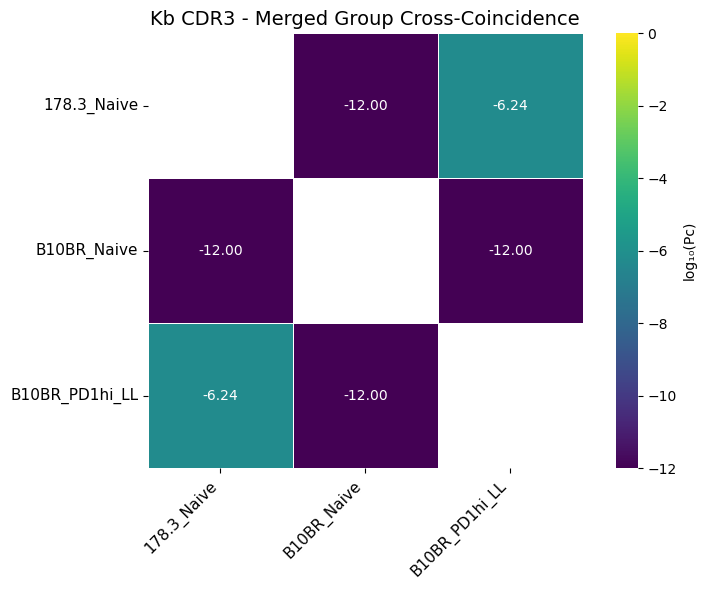


Kd (CDR3)
Building merged groups for Kd
  Including B6Kd Naive LL -> B6Kd_Naive
  Including B6Kd Naive SLO -> B6Kd_Naive
  Including BL6 NaiveA LL -> C57BL6_Naive
  Including BL6 NaiveA SLO -> C57BL6_Naive
  Including BL6 NaiveB LL -> C57BL6_Naive
  Including BL6 NaiveB SLO -> C57BL6_Naive
  Including BL6 PD1hiA LL -> C57BL6_PD1hi_LL
  Including BL6 PD1hiB LL -> C57BL6_PD1hi_LL
  Including BL6 PD1hiC LL -> C57BL6_PD1hi_LL
  B6Kd_Naive: 2 samples, 5511 total sequences
  C57BL6_Naive: 4 samples, 7822 total sequences
  C57BL6_PD1hi_LL: 3 samples, 18449 total sequences

Computing Kd cross-matrix
  Computing 3x3 matrix...

Kd Matrix (raw pc values):
                 B6Kd_Naive  C57BL6_Naive  C57BL6_PD1hi_LL
B6Kd_Naive              NaN           0.0              0.0
C57BL6_Naive            0.0           NaN              0.0
C57BL6_PD1hi_LL         0.0           0.0              NaN
Saved: Comparison2_Merged_Heatmaps/Kd_CDR3_merged_heatmap.svg


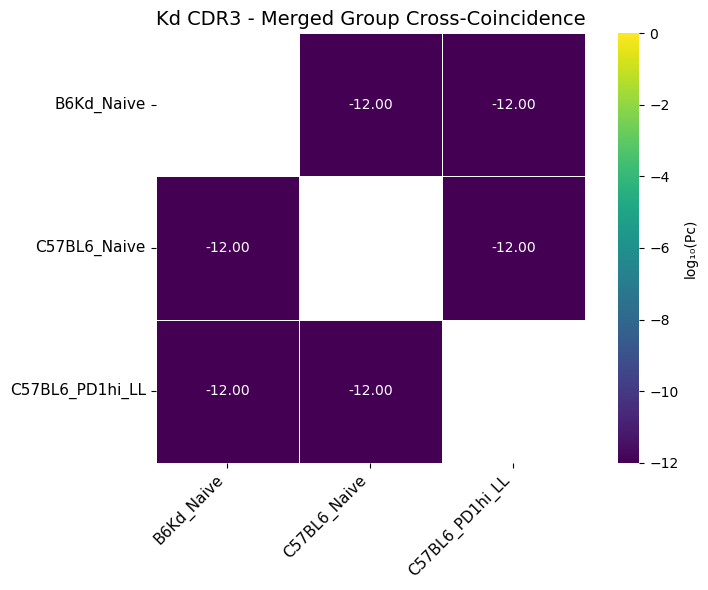

Processing CDR3a

Kb (CDR3a)
Building merged groups
  Including 1783 Naive LL -> 178.3_Naive
  Including 1783 Naive SLO -> 178.3_Naive
  Including B10BR NaiveA LL -> B10BR_Naive
  Including B10BR NaiveA SLO -> B10BR_Naive
  Including B10BR NaiveB LL -> B10BR_Naive
  Including B10BR NaiveB SLO -> B10BR_Naive
  Including B10BR PD1hiA LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiB LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiC LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiD LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiE LL -> B10BR_PD1hi_LL
  178.3_Naive: 2 samples, 10673 total sequences
  B10BR_Naive: 4 samples, 6253 total sequences
  B10BR_PD1hi_LL: 5 samples, 26126 total sequences

Computing Kb cross-matrix
  Computing 3x3 matrix...

Kb Matrix (raw pc values):
                178.3_Naive  B10BR_Naive  B10BR_PD1hi_LL
178.3_Naive             NaN     0.000109         0.00041
B10BR_Naive        0.000109          NaN         0.00009
B10BR_PD1hi_LL     0.000410     0.000090             NaN
Saved:

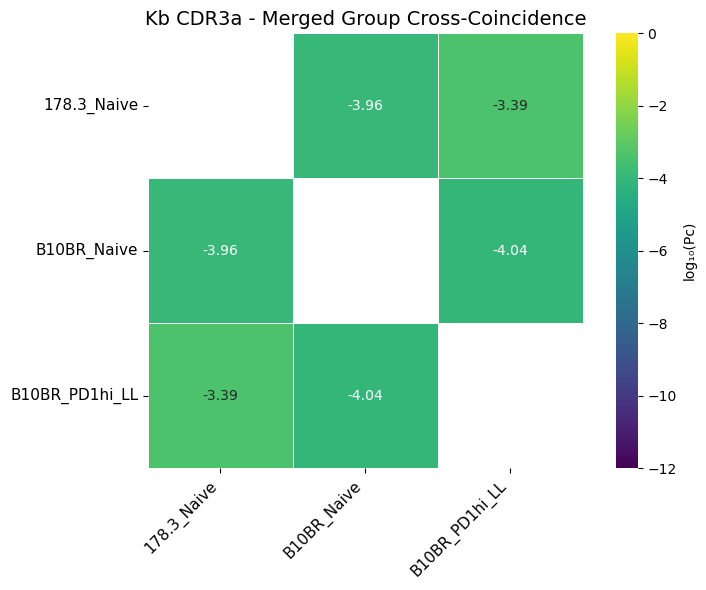


Kd (CDR3a)
Building merged groups for Kd
  Including B6Kd Naive LL -> B6Kd_Naive
  Including B6Kd Naive SLO -> B6Kd_Naive
  Including BL6 NaiveA LL -> C57BL6_Naive
  Including BL6 NaiveA SLO -> C57BL6_Naive
  Including BL6 NaiveB LL -> C57BL6_Naive
  Including BL6 NaiveB SLO -> C57BL6_Naive
  Including BL6 PD1hiA LL -> C57BL6_PD1hi_LL
  Including BL6 PD1hiB LL -> C57BL6_PD1hi_LL
  Including BL6 PD1hiC LL -> C57BL6_PD1hi_LL
  B6Kd_Naive: 2 samples, 5511 total sequences
  C57BL6_Naive: 4 samples, 7822 total sequences
  C57BL6_PD1hi_LL: 3 samples, 18449 total sequences

Computing Kd cross-matrix
  Computing 3x3 matrix...

Kd Matrix (raw pc values):
                 B6Kd_Naive  C57BL6_Naive  C57BL6_PD1hi_LL
B6Kd_Naive              NaN      0.000072         0.000035
C57BL6_Naive       0.000072           NaN         0.000056
C57BL6_PD1hi_LL    0.000035      0.000056              NaN
Saved: Comparison2_Merged_Heatmaps/Kd_CDR3a_merged_heatmap.svg


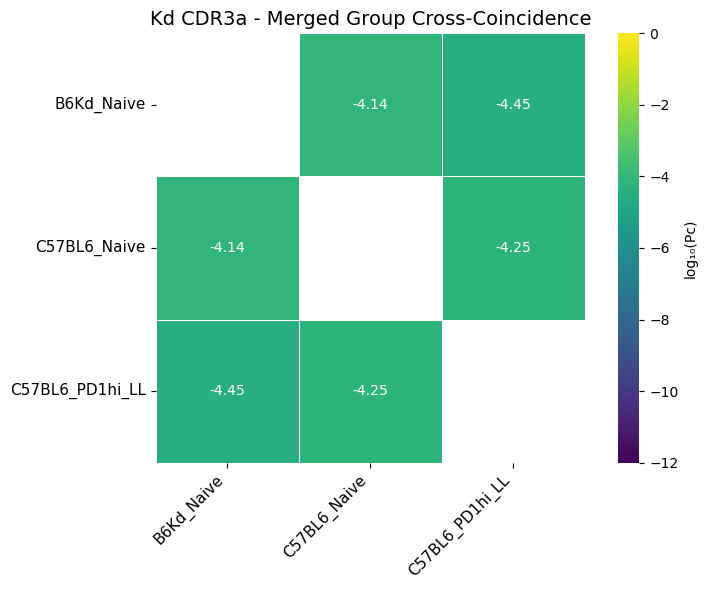

Processing CDR3b

Kb (CDR3b)
Building merged groups
  Including 1783 Naive LL -> 178.3_Naive
  Including 1783 Naive SLO -> 178.3_Naive
  Including B10BR NaiveA LL -> B10BR_Naive
  Including B10BR NaiveA SLO -> B10BR_Naive
  Including B10BR NaiveB LL -> B10BR_Naive
  Including B10BR NaiveB SLO -> B10BR_Naive
  Including B10BR PD1hiA LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiB LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiC LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiD LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiE LL -> B10BR_PD1hi_LL
  178.3_Naive: 2 samples, 10673 total sequences
  B10BR_Naive: 4 samples, 6253 total sequences
  B10BR_PD1hi_LL: 5 samples, 26126 total sequences

Computing Kb cross-matrix
  Computing 3x3 matrix...

Kb Matrix (raw pc values):
                178.3_Naive  B10BR_Naive  B10BR_PD1hi_LL
178.3_Naive             NaN     0.000018        0.000018
B10BR_Naive        0.000018          NaN        0.000008
B10BR_PD1hi_LL     0.000018     0.000008             NaN
Saved:

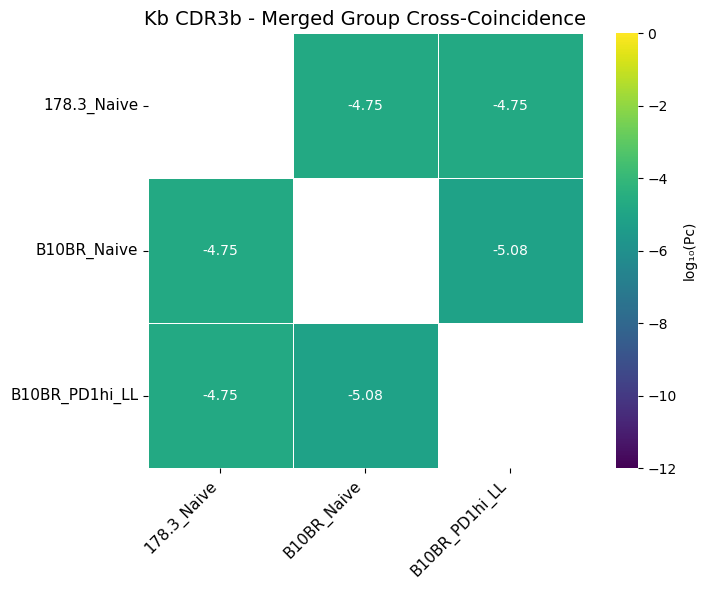


Kd (CDR3b)
Building merged groups for Kd
  Including B6Kd Naive LL -> B6Kd_Naive
  Including B6Kd Naive SLO -> B6Kd_Naive
  Including BL6 NaiveA LL -> C57BL6_Naive
  Including BL6 NaiveA SLO -> C57BL6_Naive
  Including BL6 NaiveB LL -> C57BL6_Naive
  Including BL6 NaiveB SLO -> C57BL6_Naive
  Including BL6 PD1hiA LL -> C57BL6_PD1hi_LL
  Including BL6 PD1hiB LL -> C57BL6_PD1hi_LL
  Including BL6 PD1hiC LL -> C57BL6_PD1hi_LL
  B6Kd_Naive: 2 samples, 5511 total sequences
  C57BL6_Naive: 4 samples, 7822 total sequences
  C57BL6_PD1hi_LL: 3 samples, 18449 total sequences

Computing Kd cross-matrix
  Computing 3x3 matrix...

Kd Matrix (raw pc values):
                 B6Kd_Naive  C57BL6_Naive  C57BL6_PD1hi_LL
B6Kd_Naive              NaN      0.000018         0.000023
C57BL6_Naive       0.000018           NaN         0.000023
C57BL6_PD1hi_LL    0.000023      0.000023              NaN
Saved: Comparison2_Merged_Heatmaps/Kd_CDR3b_merged_heatmap.svg


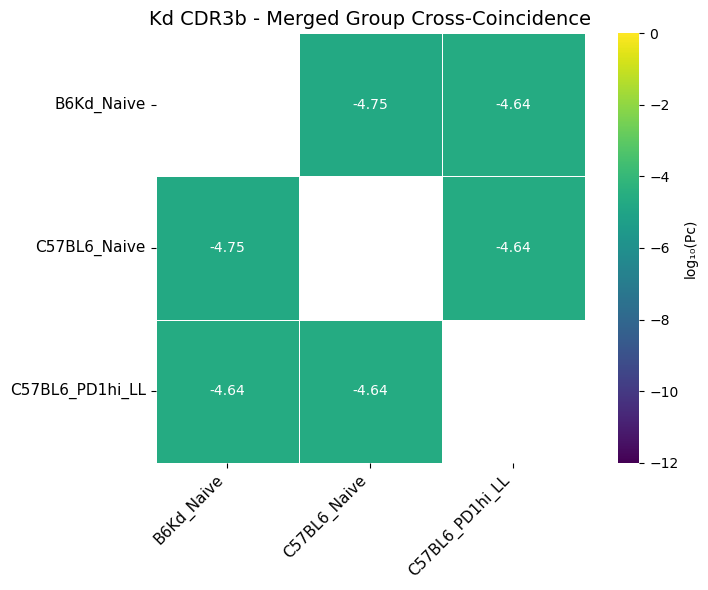

Processing FullChain

Kb (FullChain)
Building merged groups
  Including 1783 Naive LL -> 178.3_Naive
  Including 1783 Naive SLO -> 178.3_Naive
  Including B10BR NaiveA LL -> B10BR_Naive
  Including B10BR NaiveA SLO -> B10BR_Naive
  Including B10BR NaiveB LL -> B10BR_Naive
  Including B10BR NaiveB SLO -> B10BR_Naive
  Including B10BR PD1hiA LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiB LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiC LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiD LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiE LL -> B10BR_PD1hi_LL
  178.3_Naive: 2 samples, 10673 total sequences
  B10BR_Naive: 4 samples, 6253 total sequences
  B10BR_PD1hi_LL: 5 samples, 26126 total sequences

Computing Kb cross-matrix
  Computing 3x3 matrix...

Kb Matrix (raw pc values):
                 178.3_Naive  B10BR_Naive  B10BR_PD1hi_LL
178.3_Naive              NaN          0.0    5.702138e-07
B10BR_Naive     0.000000e+00          NaN    0.000000e+00
B10BR_PD1hi_LL  5.702138e-07          0.0           

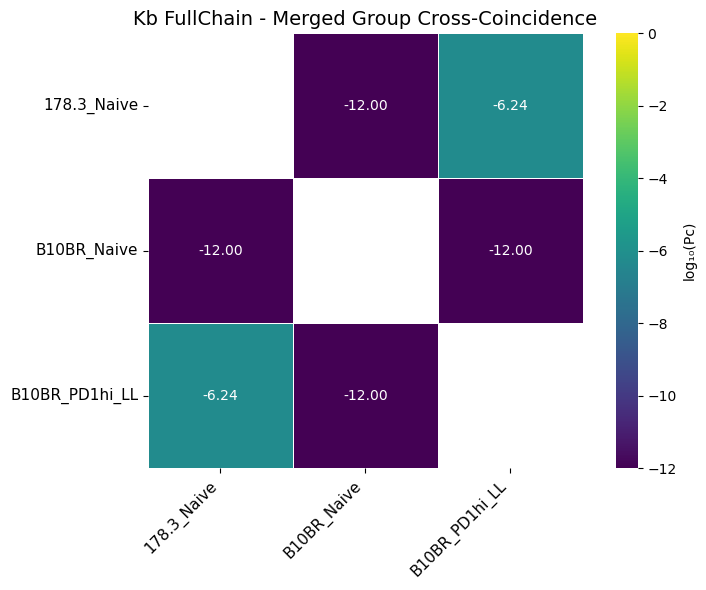


Kd (FullChain)
Building merged groups for Kd
  Including B6Kd Naive LL -> B6Kd_Naive
  Including B6Kd Naive SLO -> B6Kd_Naive
  Including BL6 NaiveA LL -> C57BL6_Naive
  Including BL6 NaiveA SLO -> C57BL6_Naive
  Including BL6 NaiveB LL -> C57BL6_Naive
  Including BL6 NaiveB SLO -> C57BL6_Naive
  Including BL6 PD1hiA LL -> C57BL6_PD1hi_LL
  Including BL6 PD1hiB LL -> C57BL6_PD1hi_LL
  Including BL6 PD1hiC LL -> C57BL6_PD1hi_LL
  B6Kd_Naive: 2 samples, 5511 total sequences
  C57BL6_Naive: 4 samples, 7822 total sequences
  C57BL6_PD1hi_LL: 3 samples, 18449 total sequences

Computing Kd cross-matrix
  Computing 3x3 matrix...

Kd Matrix (raw pc values):
                 B6Kd_Naive  C57BL6_Naive  C57BL6_PD1hi_LL
B6Kd_Naive              NaN           0.0              0.0
C57BL6_Naive            0.0           NaN              0.0
C57BL6_PD1hi_LL         0.0           0.0              NaN
Saved: Comparison2_Merged_Heatmaps/Kd_FullChain_merged_heatmap.svg


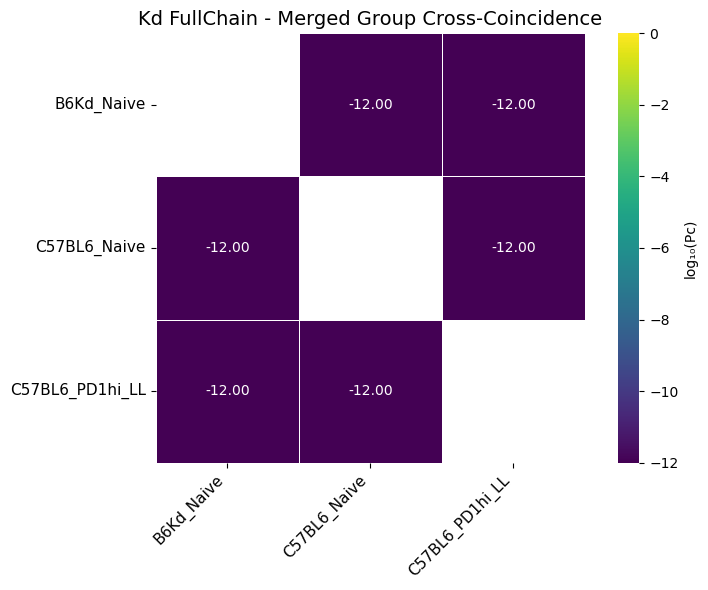

Processing FullAlpha

Kb (FullAlpha)
Building merged groups
  Including 1783 Naive LL -> 178.3_Naive
  Including 1783 Naive SLO -> 178.3_Naive
  Including B10BR NaiveA LL -> B10BR_Naive
  Including B10BR NaiveA SLO -> B10BR_Naive
  Including B10BR NaiveB LL -> B10BR_Naive
  Including B10BR NaiveB SLO -> B10BR_Naive
  Including B10BR PD1hiA LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiB LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiC LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiD LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiE LL -> B10BR_PD1hi_LL
  178.3_Naive: 2 samples, 10673 total sequences
  B10BR_Naive: 4 samples, 6253 total sequences
  B10BR_PD1hi_LL: 5 samples, 26126 total sequences

Computing Kb cross-matrix
  Computing 3x3 matrix...

Kb Matrix (raw pc values):
                178.3_Naive  B10BR_Naive  B10BR_PD1hi_LL
178.3_Naive             NaN      0.00002         0.00006
B10BR_Naive         0.00002          NaN         0.00001
B10BR_PD1hi_LL      0.00006      0.00001             Na

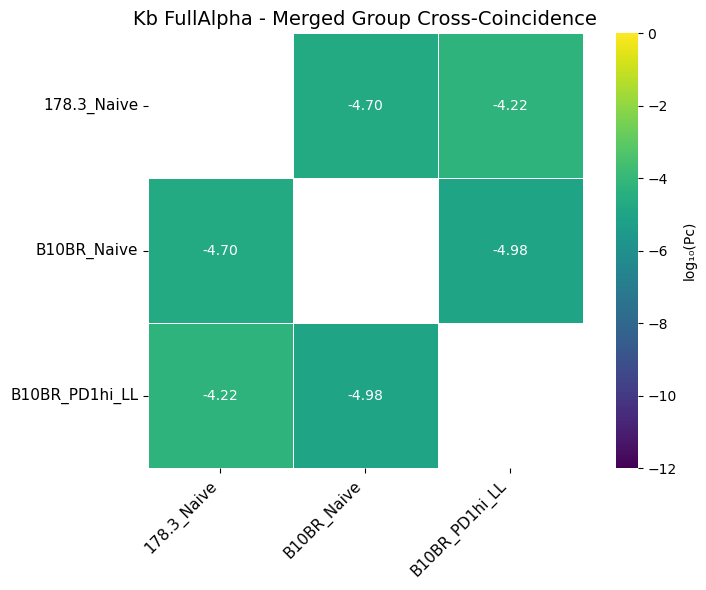


Kd (FullAlpha)
Building merged groups for Kd
  Including B6Kd Naive LL -> B6Kd_Naive
  Including B6Kd Naive SLO -> B6Kd_Naive
  Including BL6 NaiveA LL -> C57BL6_Naive
  Including BL6 NaiveA SLO -> C57BL6_Naive
  Including BL6 NaiveB LL -> C57BL6_Naive
  Including BL6 NaiveB SLO -> C57BL6_Naive
  Including BL6 PD1hiA LL -> C57BL6_PD1hi_LL
  Including BL6 PD1hiB LL -> C57BL6_PD1hi_LL
  Including BL6 PD1hiC LL -> C57BL6_PD1hi_LL
  B6Kd_Naive: 2 samples, 5511 total sequences
  C57BL6_Naive: 4 samples, 7822 total sequences
  C57BL6_PD1hi_LL: 3 samples, 18449 total sequences

Computing Kd cross-matrix
  Computing 3x3 matrix...

Kd Matrix (raw pc values):
                 B6Kd_Naive  C57BL6_Naive  C57BL6_PD1hi_LL
B6Kd_Naive              NaN      0.000016         0.000006
C57BL6_Naive       0.000016           NaN         0.000013
C57BL6_PD1hi_LL    0.000006      0.000013              NaN
Saved: Comparison2_Merged_Heatmaps/Kd_FullAlpha_merged_heatmap.svg


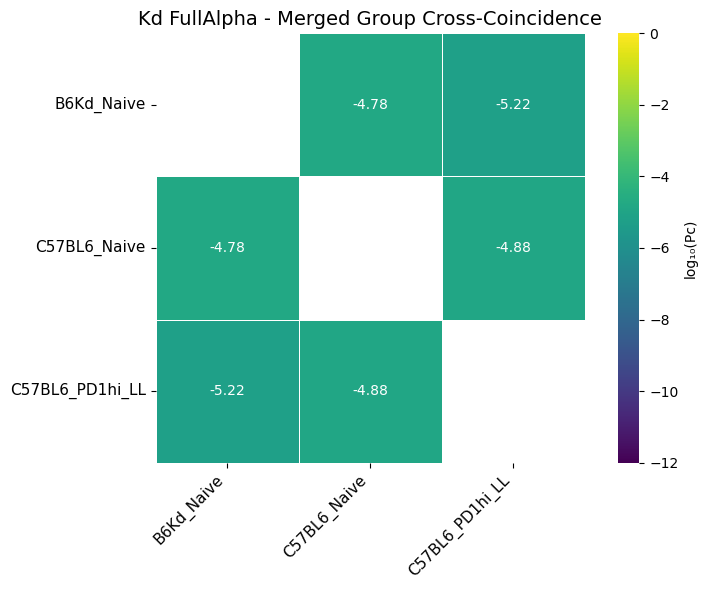

Processing FullBeta

Kb (FullBeta)
Building merged groups
  Including 1783 Naive LL -> 178.3_Naive
  Including 1783 Naive SLO -> 178.3_Naive
  Including B10BR NaiveA LL -> B10BR_Naive
  Including B10BR NaiveA SLO -> B10BR_Naive
  Including B10BR NaiveB LL -> B10BR_Naive
  Including B10BR NaiveB SLO -> B10BR_Naive
  Including B10BR PD1hiA LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiB LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiC LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiD LL -> B10BR_PD1hi_LL
  Including B10BR PD1hiE LL -> B10BR_PD1hi_LL
  178.3_Naive: 2 samples, 10673 total sequences
  B10BR_Naive: 4 samples, 6253 total sequences
  B10BR_PD1hi_LL: 5 samples, 26126 total sequences

Computing Kb cross-matrix
  Computing 3x3 matrix...

Kb Matrix (raw pc values):
                178.3_Naive  B10BR_Naive  B10BR_PD1hi_LL
178.3_Naive             NaN     0.000005        0.000007
B10BR_Naive        0.000005          NaN        0.000002
B10BR_PD1hi_LL     0.000007     0.000002             NaN


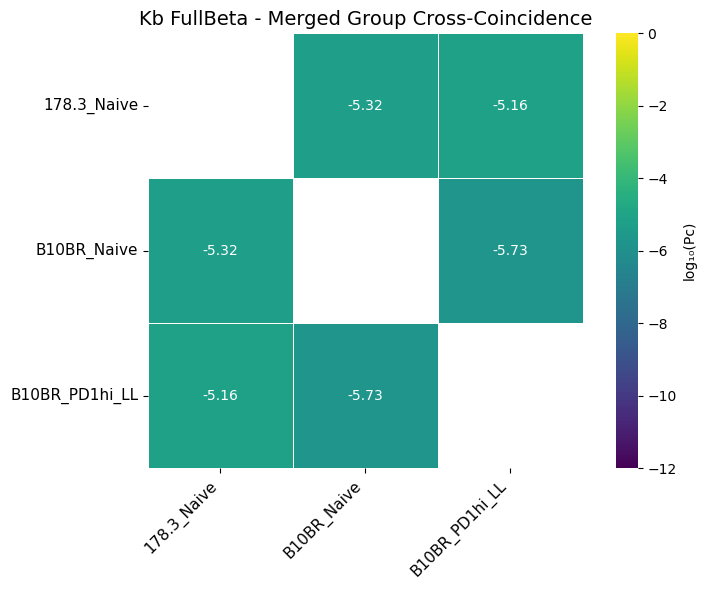


Kd (FullBeta)
Building merged groups for Kd
  Including B6Kd Naive LL -> B6Kd_Naive
  Including B6Kd Naive SLO -> B6Kd_Naive
  Including BL6 NaiveA LL -> C57BL6_Naive
  Including BL6 NaiveA SLO -> C57BL6_Naive
  Including BL6 NaiveB LL -> C57BL6_Naive
  Including BL6 NaiveB SLO -> C57BL6_Naive
  Including BL6 PD1hiA LL -> C57BL6_PD1hi_LL
  Including BL6 PD1hiB LL -> C57BL6_PD1hi_LL
  Including BL6 PD1hiC LL -> C57BL6_PD1hi_LL
  B6Kd_Naive: 2 samples, 5511 total sequences
  C57BL6_Naive: 4 samples, 7822 total sequences
  C57BL6_PD1hi_LL: 3 samples, 18449 total sequences

Computing Kd cross-matrix
  Computing 3x3 matrix...

Kd Matrix (raw pc values):
                 B6Kd_Naive  C57BL6_Naive  C57BL6_PD1hi_LL
B6Kd_Naive              NaN      0.000003         0.000004
C57BL6_Naive       0.000003           NaN         0.000009
C57BL6_PD1hi_LL    0.000004      0.000009              NaN
Saved: Comparison2_Merged_Heatmaps/Kd_FullBeta_merged_heatmap.svg


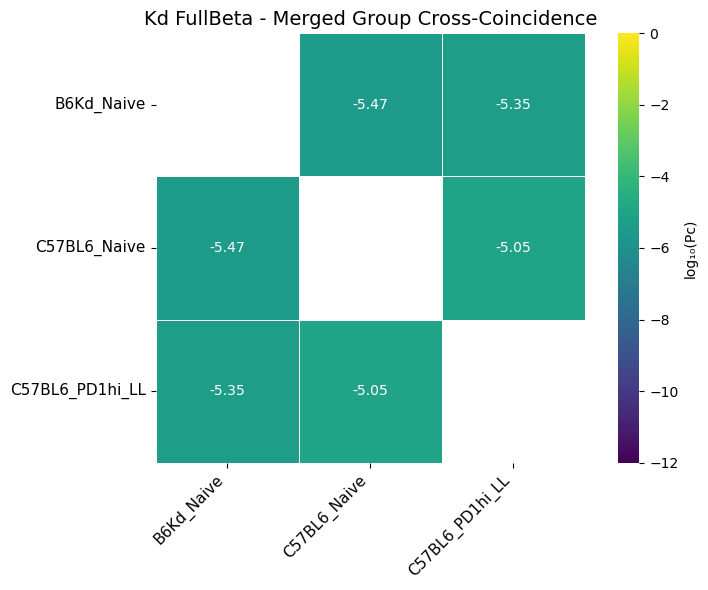

SUMMARY

Kb_CDR3:
  178.3_Naive: 2 samples
    - 1783 Naive LL
    - 1783 Naive SLO
  B10BR_Naive: 4 samples
    - B10BR NaiveA LL
    - B10BR NaiveA SLO
    - B10BR NaiveB LL
    - B10BR NaiveB SLO
  B10BR_PD1hi_LL: 5 samples
    - B10BR PD1hiA LL
    - B10BR PD1hiB LL
    - B10BR PD1hiC LL
    - B10BR PD1hiD LL
    - B10BR PD1hiE LL

Kd_CDR3:
  B6Kd_Naive: 2 samples
    - B6Kd Naive LL
    - B6Kd Naive SLO
  C57BL6_Naive: 4 samples
    - BL6 NaiveA LL
    - BL6 NaiveA SLO
    - BL6 NaiveB LL
    - BL6 NaiveB SLO
  C57BL6_PD1hi_LL: 3 samples
    - BL6 PD1hiA LL
    - BL6 PD1hiB LL
    - BL6 PD1hiC LL

Kb_CDR3a:
  178.3_Naive: 2 samples
    - 1783 Naive LL
    - 1783 Naive SLO
  B10BR_Naive: 4 samples
    - B10BR NaiveA LL
    - B10BR NaiveA SLO
    - B10BR NaiveB LL
    - B10BR NaiveB SLO
  B10BR_PD1hi_LL: 5 samples
    - B10BR PD1hiA LL
    - B10BR PD1hiB LL
    - B10BR PD1hiC LL
    - B10BR PD1hiD LL
    - B10BR PD1hiE LL

Kd_CDR3a:
  B6Kd_Naive: 2 samples
    - B6Kd Naive LL
    - 

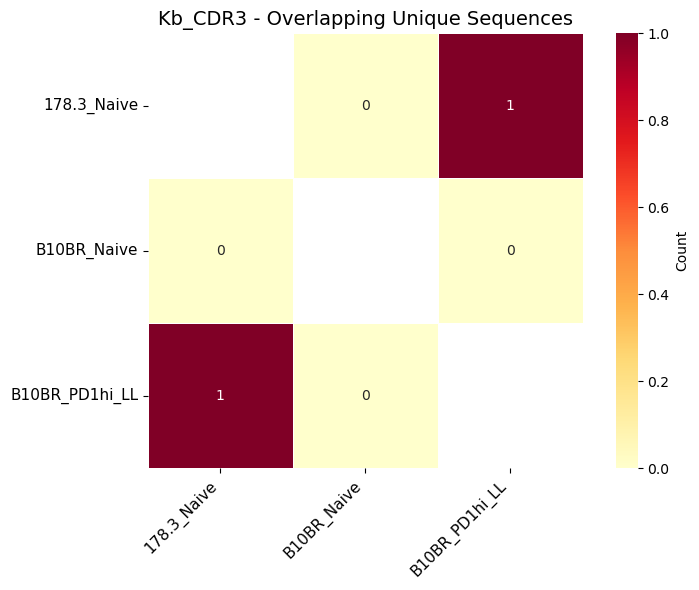

Saved: Comparison2_Merged_Heatmaps/Kb_CDR3_directional_overlap_heatmap.svg


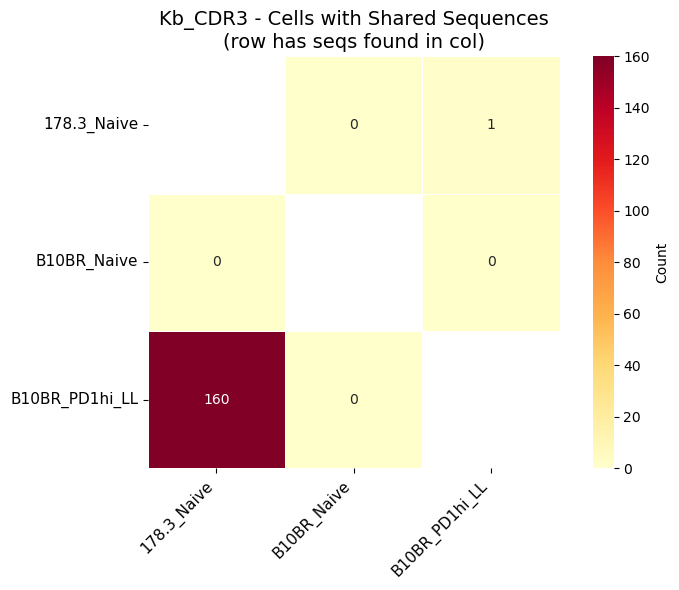


Kd_CDR3

Unique sequence overlap (diagonal = total unique in group):
                 B6Kd_Naive  C57BL6_Naive  C57BL6_PD1hi_LL
B6Kd_Naive              NaN           0.0              0.0
C57BL6_Naive            0.0           NaN              0.0
C57BL6_PD1hi_LL         0.0           0.0              NaN

Directional cell overlap (row,col = cells in 'row' with seqs found in 'col'):
                 B6Kd_Naive  C57BL6_Naive  C57BL6_PD1hi_LL
B6Kd_Naive              NaN           0.0              0.0
C57BL6_Naive            0.0           NaN              0.0
C57BL6_PD1hi_LL         0.0           0.0              NaN
Saved: Comparison2_Merged_Heatmaps/Kd_CDR3_unique_overlap_heatmap.svg


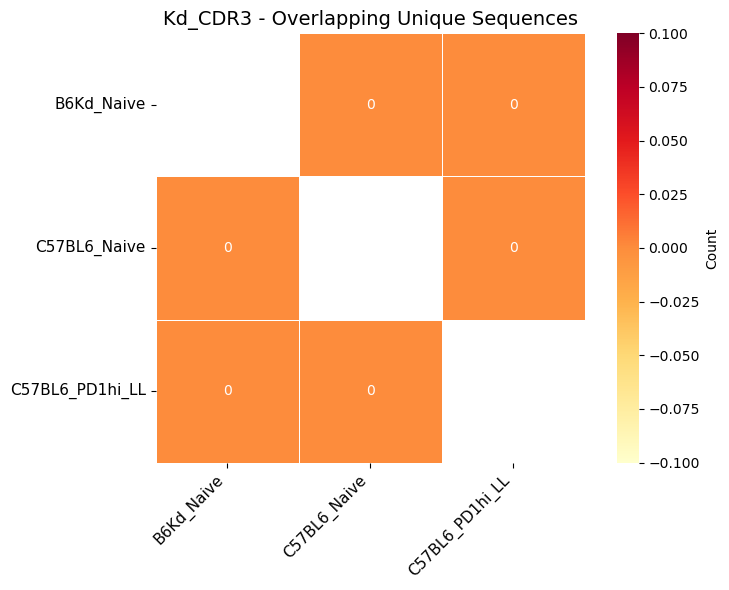

Saved: Comparison2_Merged_Heatmaps/Kd_CDR3_directional_overlap_heatmap.svg


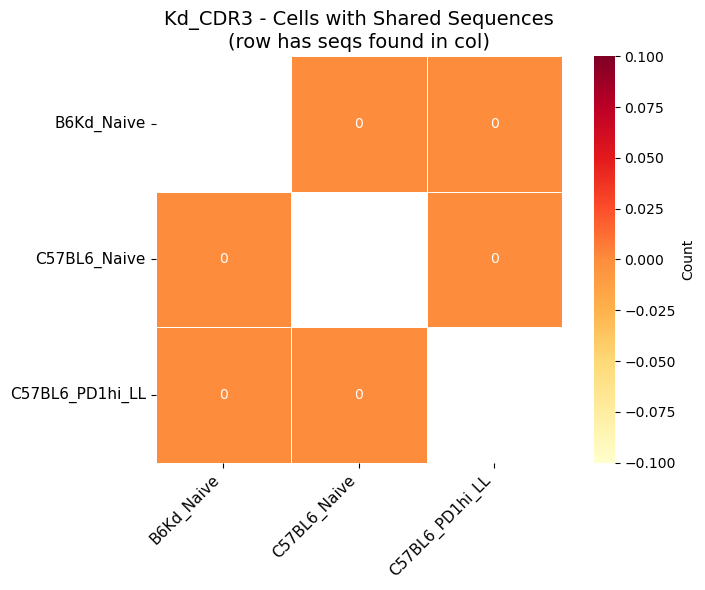


Kb_CDR3a

Unique sequence overlap (diagonal = total unique in group):
                178.3_Naive  B10BR_Naive  B10BR_PD1hi_LL
178.3_Naive             NaN        788.0           929.0
B10BR_Naive           788.0          NaN           553.0
B10BR_PD1hi_LL        929.0        553.0             NaN

Directional cell overlap (row,col = cells in 'row' with seqs found in 'col'):
                178.3_Naive  B10BR_Naive  B10BR_PD1hi_LL
178.3_Naive             NaN       2989.0          3326.0
B10BR_Naive          1308.0          NaN           950.0
B10BR_PD1hi_LL      11279.0       5210.0             NaN
Saved: Comparison2_Merged_Heatmaps/Kb_CDR3a_unique_overlap_heatmap.svg


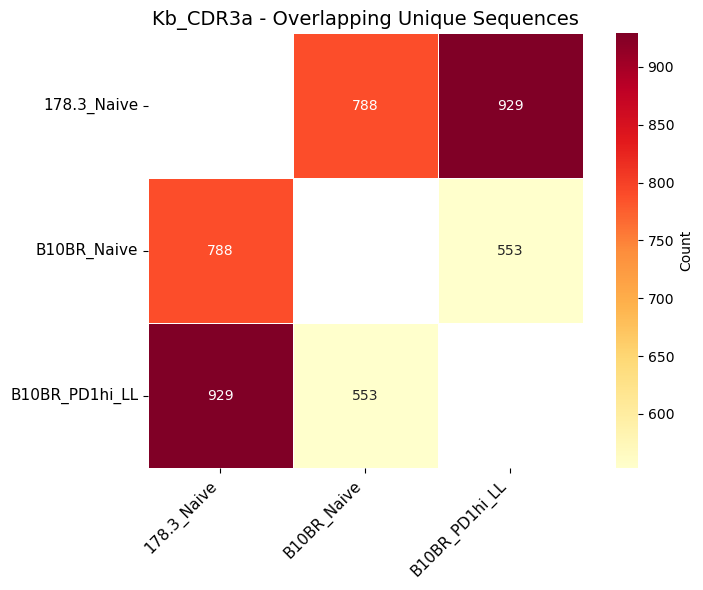

Saved: Comparison2_Merged_Heatmaps/Kb_CDR3a_directional_overlap_heatmap.svg


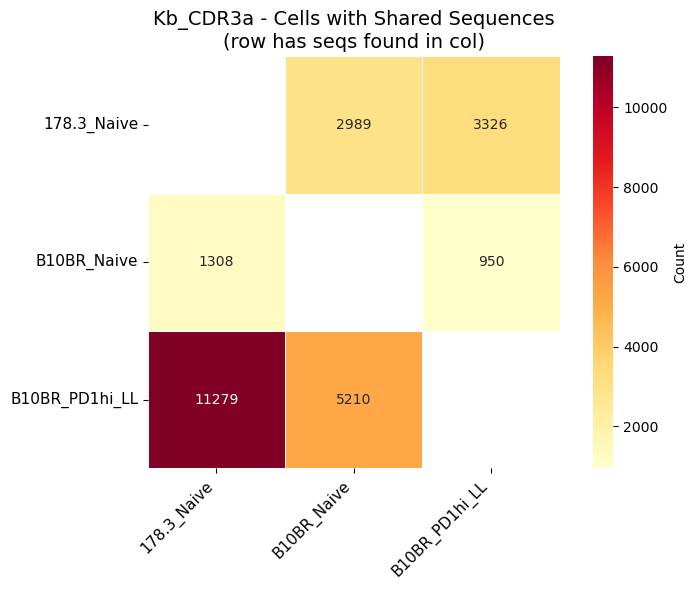


Kd_CDR3a

Unique sequence overlap (diagonal = total unique in group):
                 B6Kd_Naive  C57BL6_Naive  C57BL6_PD1hi_LL
B6Kd_Naive              NaN         660.0            333.0
C57BL6_Naive          660.0           NaN            449.0
C57BL6_PD1hi_LL       333.0         449.0              NaN

Directional cell overlap (row,col = cells in 'row' with seqs found in 'col'):
                 B6Kd_Naive  C57BL6_Naive  C57BL6_PD1hi_LL
B6Kd_Naive              NaN        1047.0            573.0
C57BL6_Naive         1308.0           NaN            978.0
C57BL6_PD1hi_LL      2062.0        3515.0              NaN
Saved: Comparison2_Merged_Heatmaps/Kd_CDR3a_unique_overlap_heatmap.svg


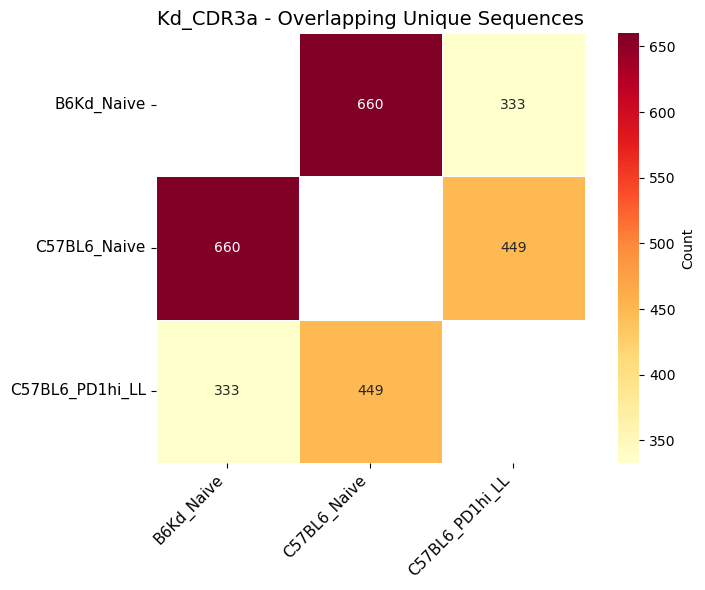

Saved: Comparison2_Merged_Heatmaps/Kd_CDR3a_directional_overlap_heatmap.svg


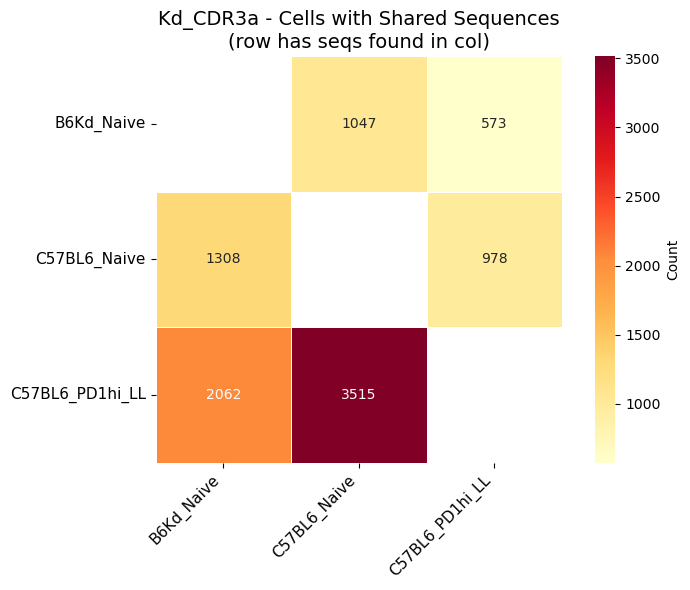


Kb_CDR3b

Unique sequence overlap (diagonal = total unique in group):
                178.3_Naive  B10BR_Naive  B10BR_PD1hi_LL
178.3_Naive             NaN        400.0           381.0
B10BR_Naive           400.0          NaN           164.0
B10BR_PD1hi_LL        381.0        164.0             NaN

Directional cell overlap (row,col = cells in 'row' with seqs found in 'col'):
                178.3_Naive  B10BR_Naive  B10BR_PD1hi_LL
178.3_Naive             NaN        674.0           671.0
B10BR_Naive           558.0          NaN           247.0
B10BR_PD1hi_LL       3190.0        785.0             NaN
Saved: Comparison2_Merged_Heatmaps/Kb_CDR3b_unique_overlap_heatmap.svg


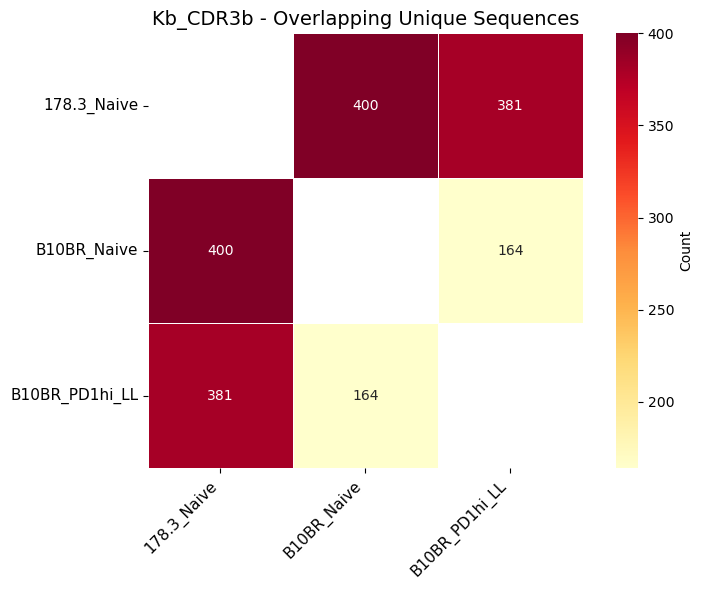

Saved: Comparison2_Merged_Heatmaps/Kb_CDR3b_directional_overlap_heatmap.svg


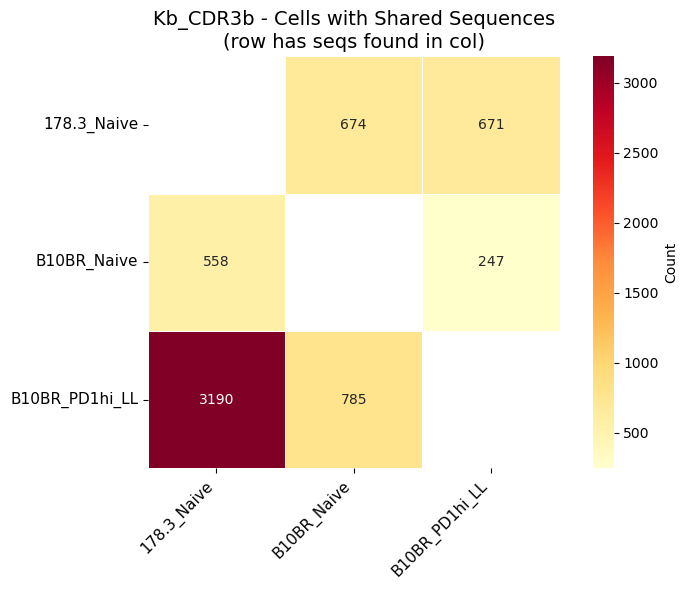


Kd_CDR3b

Unique sequence overlap (diagonal = total unique in group):
                 B6Kd_Naive  C57BL6_Naive  C57BL6_PD1hi_LL
B6Kd_Naive              NaN         311.0            113.0
C57BL6_Naive          311.0           NaN            175.0
C57BL6_PD1hi_LL       113.0         175.0              NaN

Directional cell overlap (row,col = cells in 'row' with seqs found in 'col'):
                 B6Kd_Naive  C57BL6_Naive  C57BL6_PD1hi_LL
B6Kd_Naive              NaN         493.0            149.0
C57BL6_Naive          469.0           NaN            261.0
C57BL6_PD1hi_LL      1331.0        1971.0              NaN
Saved: Comparison2_Merged_Heatmaps/Kd_CDR3b_unique_overlap_heatmap.svg


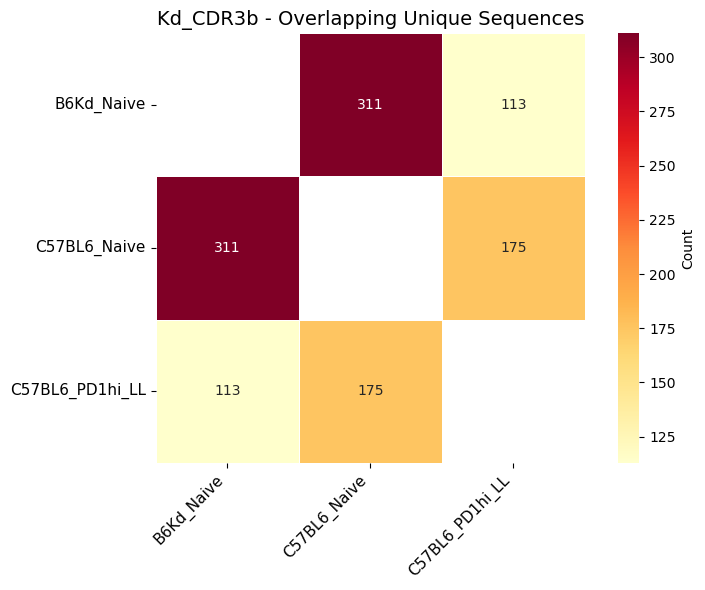

Saved: Comparison2_Merged_Heatmaps/Kd_CDR3b_directional_overlap_heatmap.svg


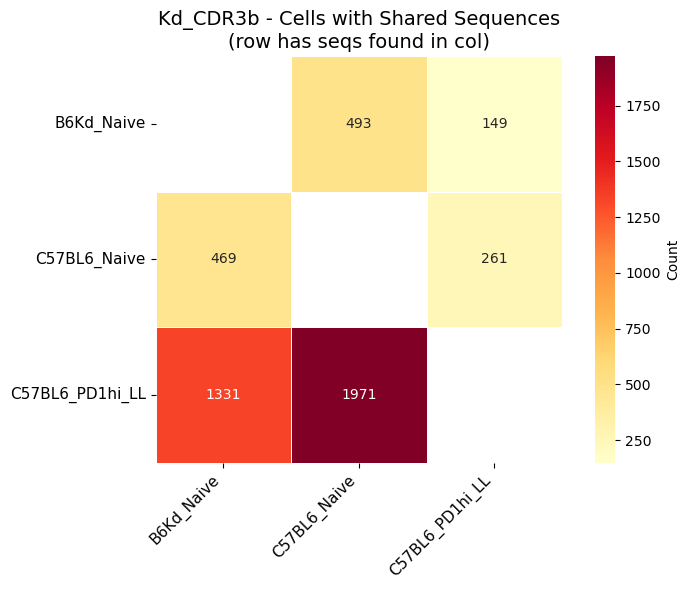


Kb_FullChain

Unique sequence overlap (diagonal = total unique in group):
                178.3_Naive  B10BR_Naive  B10BR_PD1hi_LL
178.3_Naive             NaN          0.0             1.0
B10BR_Naive             0.0          NaN             0.0
B10BR_PD1hi_LL          1.0          0.0             NaN

Directional cell overlap (row,col = cells in 'row' with seqs found in 'col'):
                178.3_Naive  B10BR_Naive  B10BR_PD1hi_LL
178.3_Naive             NaN          0.0             1.0
B10BR_Naive             0.0          NaN             0.0
B10BR_PD1hi_LL        159.0          0.0             NaN
Saved: Comparison2_Merged_Heatmaps/Kb_FullChain_unique_overlap_heatmap.svg


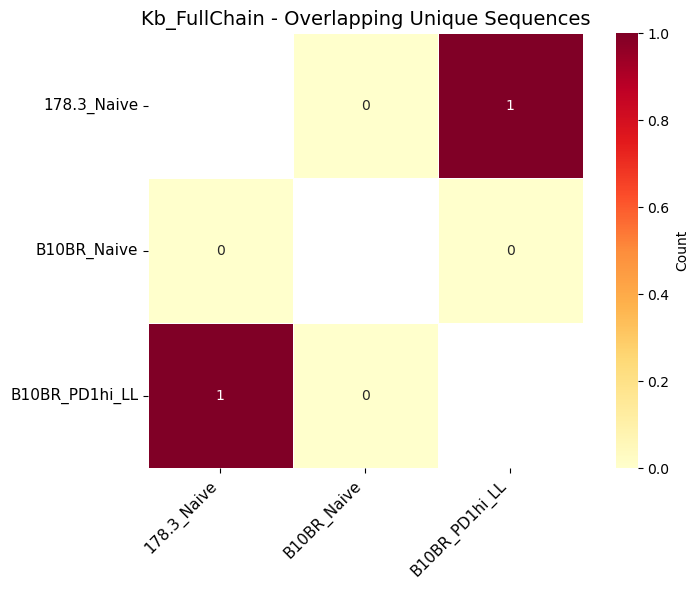

Saved: Comparison2_Merged_Heatmaps/Kb_FullChain_directional_overlap_heatmap.svg


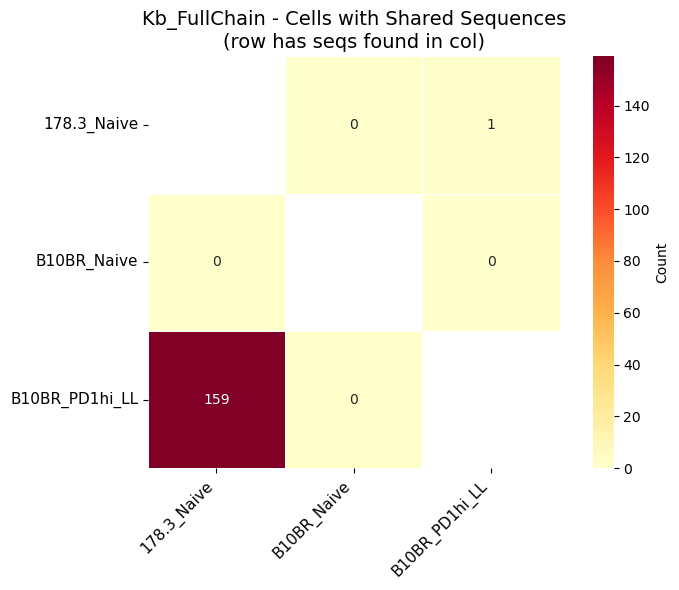


Kd_FullChain

Unique sequence overlap (diagonal = total unique in group):
                 B6Kd_Naive  C57BL6_Naive  C57BL6_PD1hi_LL
B6Kd_Naive              NaN           0.0              0.0
C57BL6_Naive            0.0           NaN              0.0
C57BL6_PD1hi_LL         0.0           0.0              NaN

Directional cell overlap (row,col = cells in 'row' with seqs found in 'col'):
                 B6Kd_Naive  C57BL6_Naive  C57BL6_PD1hi_LL
B6Kd_Naive              NaN           0.0              0.0
C57BL6_Naive            0.0           NaN              0.0
C57BL6_PD1hi_LL         0.0           0.0              NaN
Saved: Comparison2_Merged_Heatmaps/Kd_FullChain_unique_overlap_heatmap.svg


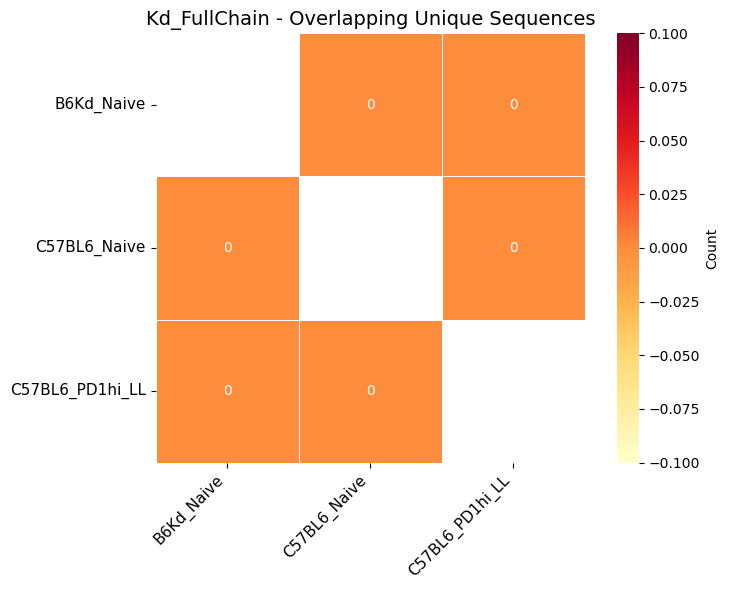

Saved: Comparison2_Merged_Heatmaps/Kd_FullChain_directional_overlap_heatmap.svg


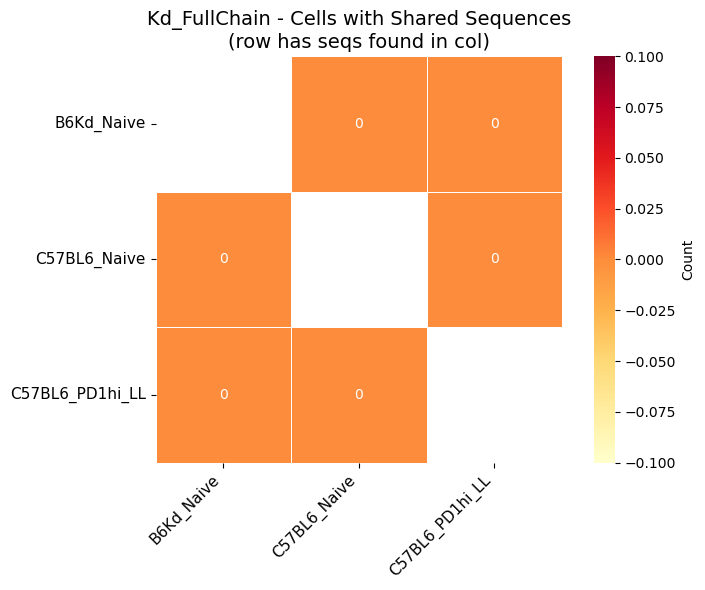


Kb_FullAlpha

Unique sequence overlap (diagonal = total unique in group):
                178.3_Naive  B10BR_Naive  B10BR_PD1hi_LL
178.3_Naive             NaN        190.0           351.0
B10BR_Naive           190.0          NaN           158.0
B10BR_PD1hi_LL        351.0        158.0             NaN

Directional cell overlap (row,col = cells in 'row' with seqs found in 'col'):
                178.3_Naive  B10BR_Naive  B10BR_PD1hi_LL
178.3_Naive             NaN        956.0          1183.0
B10BR_Naive           248.0          NaN           227.0
B10BR_PD1hi_LL       5180.0       1184.0             NaN
Saved: Comparison2_Merged_Heatmaps/Kb_FullAlpha_unique_overlap_heatmap.svg


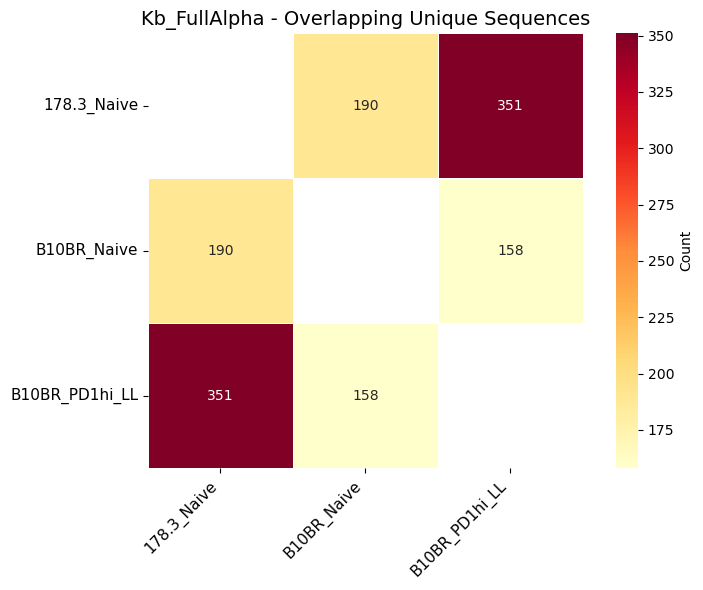

Saved: Comparison2_Merged_Heatmaps/Kb_FullAlpha_directional_overlap_heatmap.svg


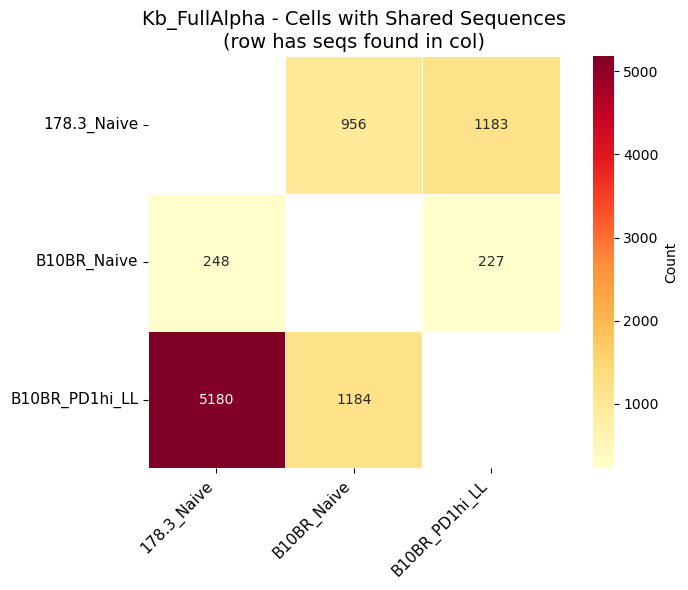


Kd_FullAlpha

Unique sequence overlap (diagonal = total unique in group):
                 B6Kd_Naive  C57BL6_Naive  C57BL6_PD1hi_LL
B6Kd_Naive              NaN         198.0            104.0
C57BL6_Naive          198.0           NaN            131.0
C57BL6_PD1hi_LL       104.0         131.0              NaN

Directional cell overlap (row,col = cells in 'row' with seqs found in 'col'):
                 B6Kd_Naive  C57BL6_Naive  C57BL6_PD1hi_LL
B6Kd_Naive              NaN         274.0            155.0
C57BL6_Naive          341.0           NaN            220.0
C57BL6_PD1hi_LL       407.0        1105.0              NaN
Saved: Comparison2_Merged_Heatmaps/Kd_FullAlpha_unique_overlap_heatmap.svg


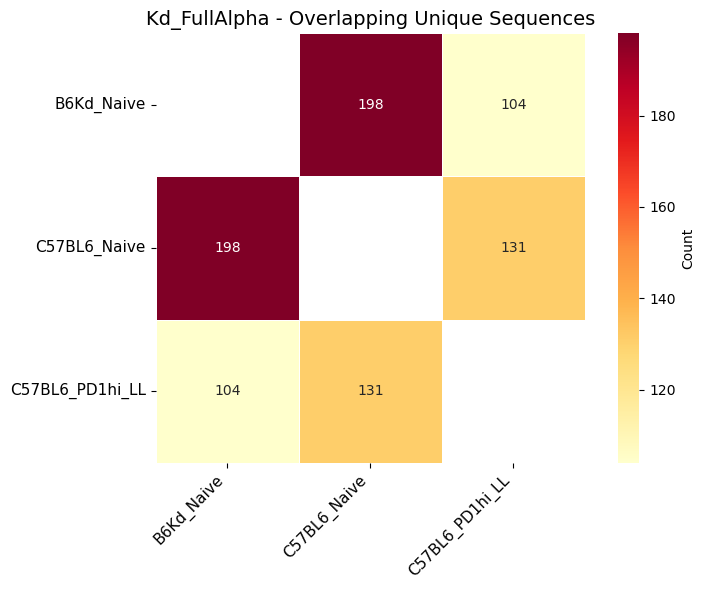

Saved: Comparison2_Merged_Heatmaps/Kd_FullAlpha_directional_overlap_heatmap.svg


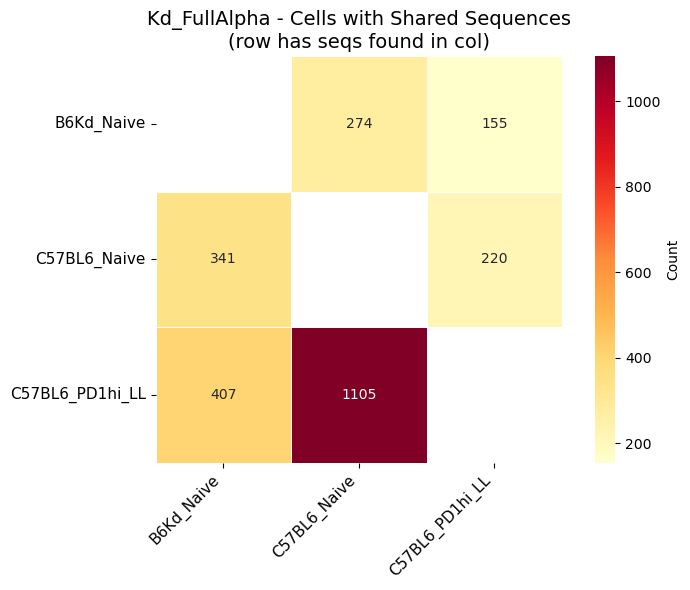


Kb_FullBeta

Unique sequence overlap (diagonal = total unique in group):
                178.3_Naive  B10BR_Naive  B10BR_PD1hi_LL
178.3_Naive             NaN        142.0           167.0
B10BR_Naive           142.0          NaN            78.0
B10BR_PD1hi_LL        167.0         78.0             NaN

Directional cell overlap (row,col = cells in 'row' with seqs found in 'col'):
                178.3_Naive  B10BR_Naive  B10BR_PD1hi_LL
178.3_Naive             NaN        208.0           253.0
B10BR_Naive           222.0          NaN            94.0
B10BR_PD1hi_LL       1730.0        269.0             NaN
Saved: Comparison2_Merged_Heatmaps/Kb_FullBeta_unique_overlap_heatmap.svg


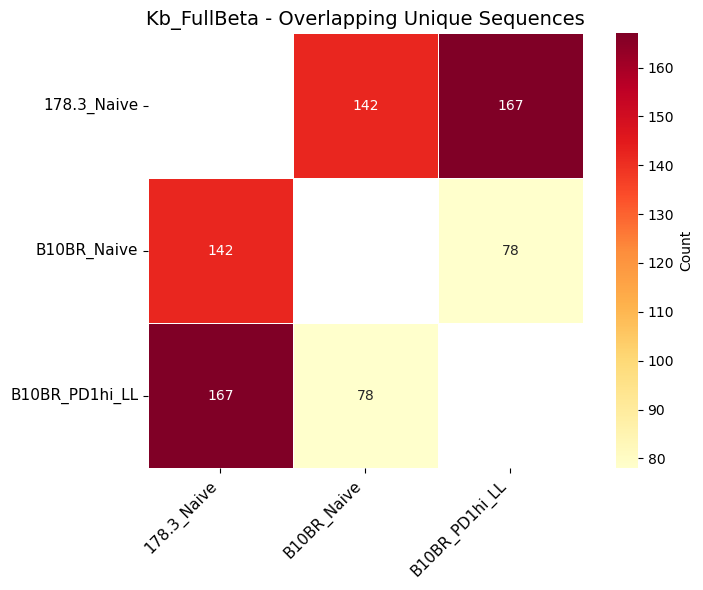

Saved: Comparison2_Merged_Heatmaps/Kb_FullBeta_directional_overlap_heatmap.svg


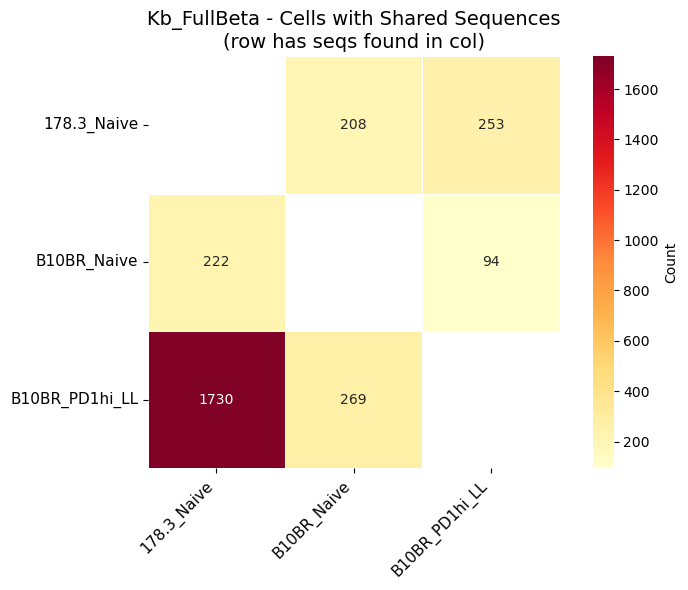


Kd_FullBeta

Unique sequence overlap (diagonal = total unique in group):
                 B6Kd_Naive  C57BL6_Naive  C57BL6_PD1hi_LL
B6Kd_Naive              NaN         100.0             26.0
C57BL6_Naive          100.0           NaN             60.0
C57BL6_PD1hi_LL        26.0          60.0              NaN

Directional cell overlap (row,col = cells in 'row' with seqs found in 'col'):
                 B6Kd_Naive  C57BL6_Naive  C57BL6_PD1hi_LL
B6Kd_Naive              NaN         120.0             32.0
C57BL6_Naive          117.0           NaN             71.0
C57BL6_PD1hi_LL       283.0         814.0              NaN
Saved: Comparison2_Merged_Heatmaps/Kd_FullBeta_unique_overlap_heatmap.svg


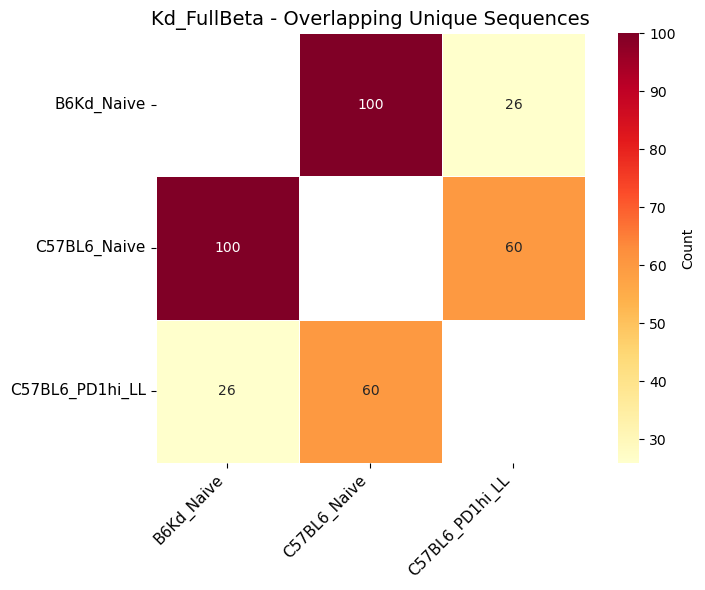

Saved: Comparison2_Merged_Heatmaps/Kd_FullBeta_directional_overlap_heatmap.svg


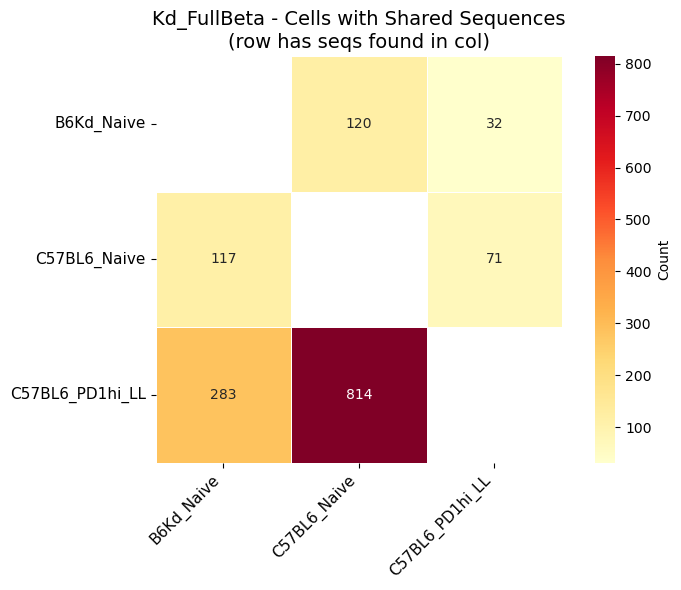

In [42]:
if __name__ == "__main__":
    results = main()
    
    # Compute and plot overlap counts
    overlap_results = compute_and_plot_overlaps(results, output_dir)

In [43]:
kb_combined = results["Kb_CDR3"]["combined_dfs"]

a = kb_combined["178.3_Naive"]["CDR3"].value_counts()
b = kb_combined["B10BR_PD1hi_LL"]["CDR3"].value_counts()

shared = a.index.intersection(b.index)

print("Number of shared sequences:", len(shared))
print("Shared sequences:")
print(shared)

print("\nCounts in 178.3_Naive:")
print(a.loc[shared])

print("\nCounts in B10BR_PD1hi_LL:")
print(b.loc[shared])

Number of shared sequences: 1
Shared sequences:
Index(['CAMREANTGYQNFYF_CASGPGGLNTLYF'], dtype='object', name='CDR3')

Counts in 178.3_Naive:
CDR3
CAMREANTGYQNFYF_CASGPGGLNTLYF    1
Name: count, dtype: int64

Counts in B10BR_PD1hi_LL:
CDR3
CAMREANTGYQNFYF_CASGPGGLNTLYF    160
Name: count, dtype: int64


In [44]:
seq = "CAMREANTGYQNFYF_CASGPGGLNTLYF"

df178 = results["Kb_CDR3"]["combined_dfs"]["178.3_Naive"]

rows = df178[df178["CDR3"].astype(str) == seq]

print("Total rows found:", len(rows))
print("\nBreakdown by original sample:")
print(rows["SampleName"].value_counts())

rows[["SampleName", "Origin"]].head()

Total rows found: 1

Breakdown by original sample:
SampleName
1783 Naive LL    1
Name: count, dtype: int64


,SampleName,Origin
782,1783 Naive LL,LL


In [45]:
seq = "CAMREANTGYQNFYF_CASGPGGLNTLYF"
df178 = results["Kb_CDR3"]["combined_dfs"]["178.3_Naive"]

rows = df178[df178["CDR3"].astype(str) == seq]
print(rows["SampleName"].value_counts())
rows.head()

SampleName
1783 Naive LL    1
Name: count, dtype: int64


,Sample_Origin,cell_id,TRA_sequence_alignment,TRB_sequence_alignment,CDR3a_nt,CDR3b_nt,TRAV,CDR3a_aa,TRAJ,TRBV,CDR3b_aa,TRBJ,TCRClonotype,CDR3,SampleName,Strain,TCRType,Origin
782,1783 Naive LL,157589,ATTCGTCAGGACTCTTACAAAAAGGAAAATGCAACAGAAGGTCATTATTCTCTGAACTTTCAGAAGCCAAAAAGTTCCATCGGACTCATCATCACTGCCACACAGATTGAGGACTCAGCAGTATATTTCTGTGCTATGAGAGAGGCGAACACGGGTTACCAGAACTTCTATTTTGGGAAAGGAACAAGTTTGACTGTCATTCCAA,ATATCCCTGAGGGATACAAGGCCACCAGACCAAGCCAAGAGAACTTCTCCCTCATTCTGGAGTTGGCTACCCCCTCTCAGACATCAGTGTACTTCTGTGCCAGCGGTCCAGGGGGCTTAAACACCTTGTACTTTGGTGCGGGCACCCGACTATCGGTGCTAG,TGTGCTATGAGAGAGGCGAACACGGGTTACCAGAACTTCTATTTT,TGTGCCAGCGGTCCAGGGGGCTTAAACACCTTGTACTTT,TRAV16*06,CAMREANTGYQNFYF,TRAJ49*01,TRBV13-2*01,CASGPGGLNTLYF,TRBJ2-4*01,AV16-CAMREANTGYQNFYF-AJ49_BV13-2-CASGPGGLNTLYF-BJ2-4,CAMREANTGYQNFYF_CASGPGGLNTLYF,1783 Naive LL,178.3,Naive,LL


In [46]:
pd1hi_df = results["Kb_CDR3"]["combined_dfs"]["B10BR_PD1hi_LL"]

print("Total PD1hi cells:", len(pd1hi_df))
print("Total unique CDR3s:", pd1hi_df["CDR3"].nunique())

Total PD1hi cells: 26126
Total unique CDR3s: 8430


In [47]:
pd1hi_counts = (
    pd1hi_df["CDR3"]
    .dropna()
    .astype(str)
    .value_counts()
    .rename("Cell_count")
    .to_frame()
)

pd1hi_counts.head(20)

,Cell_count
CDR3,
CAMRESNTGYQNFYF_CASGTGGQNTLYF,595
CAASASSGSWQLIF_CAWSLAGSGNTLYF,487
CAASSGGSNYKLTF_CASSIGRTGNTLYF,404
CAMRDNYAQGLTF_CASSLGPSSYEQYF,345
CALGEGGYKVVF_CASSQDQVGERLFF,297
CAASESNNNAPRF_CTCSADPGYEQYF,242
CAVSGNYNVLYF_CASRTGGHEQYF,230
CALSPSGSWQLIF_CASSDVGYEQYF,222
CAMREANTGYQNFYF_CASGTGGQNTLYF,222


In [48]:
pd1hi_counts["Fraction_of_PD1hi"] = (
    pd1hi_counts["Cell_count"] / pd1hi_counts["Cell_count"].sum()
)

pd1hi_counts.head(20)

,Cell_count,Fraction_of_PD1hi
CDR3,,
CAMRESNTGYQNFYF_CASGTGGQNTLYF,595,0.022774
CAASASSGSWQLIF_CAWSLAGSGNTLYF,487,0.018640
CAASSGGSNYKLTF_CASSIGRTGNTLYF,404,0.015464
CAMRDNYAQGLTF_CASSLGPSSYEQYF,345,0.013205
CALGEGGYKVVF_CASSQDQVGERLFF,297,0.011368
CAASESNNNAPRF_CTCSADPGYEQYF,242,0.009263
CAVSGNYNVLYF_CASRTGGHEQYF,230,0.008803
CALSPSGSWQLIF_CASSDVGYEQYF,222,0.008497
CAMREANTGYQNFYF_CASGTGGQNTLYF,222,0.008497


In [49]:
shared_seq = "CAMREANTGYQNFYF_CASGPGGLNTLYF"

pd1hi_counts.loc[[shared_seq]]

,Cell_count,Fraction_of_PD1hi
CDR3,,
CAMREANTGYQNFYF_CASGPGGLNTLYF,160,0.006124


In [50]:
pd1hi_df = results["Kb_CDR3"]["combined_dfs"]["B10BR_PD1hi_LL"]

summary = (pd1hi_df.dropna(subset=["CDR3", "TRAV"]).groupby(["CDR3", "TRAV"]).size().reset_index(name="Cell_count").sort_values("Cell_count", ascending=False).head(15))

summary

,CDR3,TRAV,Cell_count
5878,CAMRESNTGYQNFYF_CASGTGGQNTLYF,TRAV16*06,594
1234,CAASASSGSWQLIF_CAWSLAGSGNTLYF,TRAV14-2*02,469
2193,CAASSGGSNYKLTF_CASSIGRTGNTLYF,TRAV14D-1*01,404
5116,CAMRDNYAQGLTF_CASSLGPSSYEQYF,TRAV16N*01,345
3628,CALGEGGYKVVF_CASSQDQVGERLFF,TRAV6D-7*04,290
1583,CAASESNNNAPRF_CTCSADPGYEQYF,TRAV7-4*02,242
7579,CAVSGNYNVLYF_CASRTGGHEQYF,TRAV9-4*02,228
4619,CALSPSGSWQLIF_CASSDVGYEQYF,TRAV6N-6*01,222
2969,CAIDTNTGKLTF_CASSETGTEVFF,TRAV13-2*03,220
7797,CAVSMKGGRALIF_CASSIGGAREQYF,TRAV7-3*04,196


In [65]:
import pandas as pd

# ensure full strings are shown
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

seq = "CAMREANTGYQNFYF_CASGPGGLNTLYF"

pd1hi_df = results["Kb_CDR3"]["combined_dfs"]["B10BR_PD1hi_LL"]

out = (
    pd1hi_df
    .loc[pd1hi_df["CDR3"] == seq]
    [["TRAV", "CDR3a_aa", "CDR3b_aa", "SampleName", "Origin"]]
    .sort_values("SampleName")
)

print("Total occurrences:", len(out))

Total occurrences: 160


In [66]:
# extract AA + nucleotide information for the shared CDR3
nt_view = (
    pd1hi_df
    .loc[pd1hi_df["CDR3"] == seq]
    [[
        "TRAV", "TRAJ", "TRBV", "TRBJ",
        "CDR3a_aa", "CDR3b_aa",
        "CDR3a_nt", "CDR3b_nt",
        "SampleName", "Origin", "cell_id"
    ]]
    .sort_values("cell_id")
)

print("Total occurrences:", len(nt_view))

Total occurrences: 160


In [61]:
nt_view["NT_Clonotype"] = (
    nt_view["TRAV"] + "_" +
    nt_view["CDR3a_nt"] + "_" +
    nt_view["TRAJ"] + "_" +
    nt_view["TRBV"] + "_" +
    nt_view["CDR3b_nt"] + "_" +
    nt_view["TRBJ"]
)

nt_view["NT_Clonotype"].nunique()

2

In [62]:
nt_counts = (
    nt_view
    .value_counts("NT_Clonotype")
    .reset_index(name="CellCount")
)

nt_counts

,NT_Clonotype,CellCount
0,TRAV16*06_TGTGCTATGAGAGAGGCGAACACGGGTTACCAGAACTTCTATTTT_TRAJ49*01_TRBV13-2*01_TGTGCCAGCGGTCCAGGGGGCTTAAACACCTTGTACTTT_TRBJ2-4*01,159
1,TRAV16N*01_TGTGCTATGAGAGAGGCGAACACGGGTTACCAGAACTTCTATTTT_TRAJ49*01_TRBV13-2*01_TGTGCCAGCGGTCCAGGGGGCTTAAACACCTTGTACTTT_TRBJ2-4*01,1


In [63]:
nt_summary = (
    nt_view
    .groupby("NT_Clonotype")
    .agg(
        Cells=("cell_id", "count"),
        TRAV=("TRAV", "first"),
        TRAJ=("TRAJ", "first"),
        TRBV=("TRBV", "first"),
        TRBJ=("TRBJ", "first"),
        CDR3a_aa=("CDR3a_aa", "first"),
        CDR3b_aa=("CDR3b_aa", "first"),
        CDR3a_nt=("CDR3a_nt", "first"),
        CDR3b_nt=("CDR3b_nt", "first"),
    )
    .sort_values("Cells", ascending=False)
)

nt_summary

,Cells,TRAV,TRAJ,TRBV,TRBJ,CDR3a_aa,CDR3b_aa,CDR3a_nt,CDR3b_nt
NT_Clonotype,,,,,,,,,
TRAV16*06_TGTGCTATGAGAGAGGCGAACACGGGTTACCAGAACTTCTATTTT_TRAJ49*01_TRBV13-2*01_TGTGCCAGCGGTCCAGGGGGCTTAAACACCTTGTACTTT_TRBJ2-4*01,159,TRAV16*06,TRAJ49*01,TRBV13-2*01,TRBJ2-4*01,CAMREANTGYQNFYF,CASGPGGLNTLYF,TGTGCTATGAGAGAGGCGAACACGGGTTACCAGAACTTCTATTTT,TGTGCCAGCGGTCCAGGGGGCTTAAACACCTTGTACTTT
TRAV16N*01_TGTGCTATGAGAGAGGCGAACACGGGTTACCAGAACTTCTATTTT_TRAJ49*01_TRBV13-2*01_TGTGCCAGCGGTCCAGGGGGCTTAAACACCTTGTACTTT_TRBJ2-4*01,1,TRAV16N*01,TRAJ49*01,TRBV13-2*01,TRBJ2-4*01,CAMREANTGYQNFYF,CASGPGGLNTLYF,TGTGCTATGAGAGAGGCGAACACGGGTTACCAGAACTTCTATTTT,TGTGCCAGCGGTCCAGGGGGCTTAAACACCTTGTACTTT


In [64]:
nt_view[["CDR3a_aa", "CDR3b_aa"]].drop_duplicates()

,CDR3a_aa,CDR3b_aa
22742,CAMREANTGYQNFYF,CASGPGGLNTLYF


178.3_Naive: 10618 unique
B10BR_Naive: 6150 unique
B10BR_PD1hi_LL: 8430 unique
A∩B: 0 A∩C: 1 B∩C: 0 A∩B∩C: 0


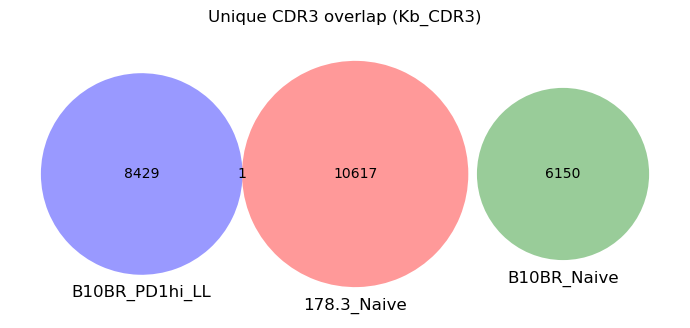

In [55]:
import matplotlib.pyplot as plt

key = "Kb_CDR3"
seq_col = "CDR3"

groupA = "178.3_Naive"
groupB = "B10BR_Naive"
groupC = "B10BR_PD1hi_LL"

combined = results[key]["combined_dfs"]

def make_set(df, col):
    s = df[col].dropna().astype(str)
    s = s[s.str.lower() != "nan"]
    return set(s)

A = make_set(combined[groupA], seq_col)
B = make_set(combined[groupB], seq_col)
C = make_set(combined[groupC], seq_col)

print(f"{groupA}: {len(A)} unique")
print(f"{groupB}: {len(B)} unique")
print(f"{groupC}: {len(C)} unique")
print("A∩B:", len(A & B), "A∩C:", len(A & C), "B∩C:", len(B & C), "A∩B∩C:", len(A & B & C))

try:
    from matplotlib_venn import venn3

    plt.figure(figsize=(7, 6))
    venn3([A, B, C], set_labels=(groupA, groupB, groupC))
    plt.title(f"Unique {seq_col} overlap ({key})")
    plt.tight_layout()
    plt.savefig(output_dir / f"{key}_venn3_{seq_col}.svg", dpi=300)
    plt.show()

except ImportError:
    print("\nmatplotlib-venn is not installed.")
    print("Install with: pip install matplotlib-venn")
    print("Fallback: printing the 7 region counts instead:\n")

    onlyA = len(A - (B | C))
    onlyB = len(B - (A | C))
    onlyC = len(C - (A | B))
    AB_only = len((A & B) - C)
    AC_only = len((A & C) - B)
    BC_only = len((B & C) - A)
    ABC = len(A & B & C)

    print("only A:", onlyA)
    print("only B:", onlyB)
    print("only C:", onlyC)
    print("A∩B only:", AB_only)
    print("A∩C only:", AC_only)
    print("B∩C only:", BC_only)
    print("A∩B∩C:", ABC)

178.3_Naive: 10618 unique
B10BR_PreImmune: 167257 unique
B10BR_PD1hi_LL: 8430 unique
A∩B: 8
A∩C: 1
B∩C: 4
A∩B∩C: 0


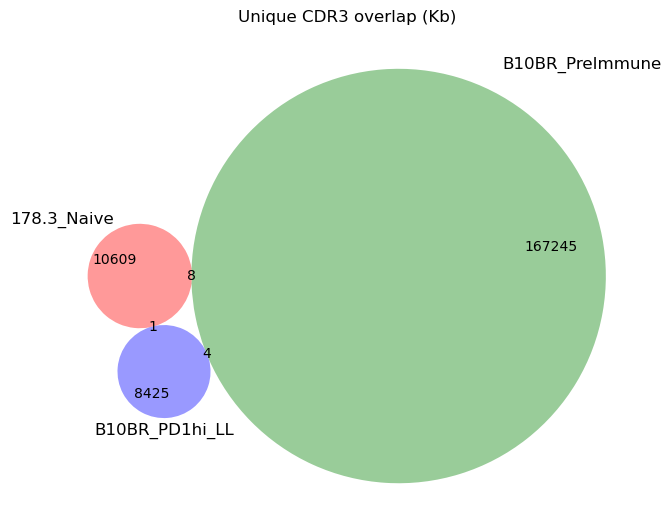

In [57]:
key = "Kb_CDR3"
seq_col = "CDR3"

groupA = "178.3_Naive"
groupC = "B10BR_PD1hi_LL"
groupB_label = "B10BR_PreImmune"

def make_set(df, col):
    s = df[col].dropna().astype(str)
    s = s[s.str.lower() != "nan"]
    return set(s)

combined = results[key]["combined_dfs"]

A = make_set(combined[groupA], seq_col)
C = make_set(combined[groupC], seq_col)

preimmune_path = Path("../Data/20250910 Comparison 2/Kb/20250910 B10BR pre-immmune TCR Repertoire.csv")

pre_df = load_and_process_sample(
    preimmune_path,
    "B10BR Pre-immune",
    target_col="CDR3"
)

B = make_set(pre_df, seq_col)

print(f"{groupA}: {len(A)} unique")
print(f"{groupB_label}: {len(B)} unique")
print(f"{groupC}: {len(C)} unique")
print("A∩B:", len(A & B))
print("A∩C:", len(A & C))
print("B∩C:", len(B & C))
print("A∩B∩C:", len(A & B & C))

from matplotlib_venn import venn3

plt.figure(figsize=(7, 6))
venn3(
    [A, B, C],
    set_labels=(groupA, groupB_label, groupC)
)
plt.title("Unique CDR3 overlap (Kb)")
plt.tight_layout()
plt.savefig(output_dir / f"{key}_venn3_CDR3_with_preimmune.svg", dpi=300)
plt.show()

Total cell counts per region:
A only: 10664
B only: 167581
C only: 25953
A∩B: 16
A∩C: 161
B∩C: 17
A∩B∩C: 0


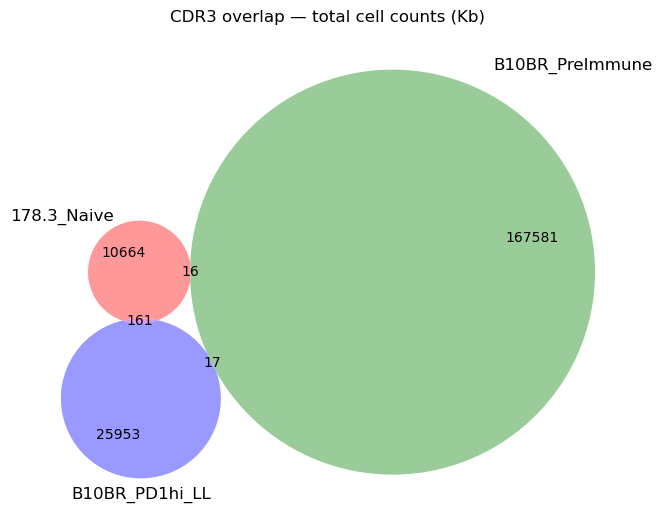

In [58]:
key = "Kb_CDR3"
seq_col = "CDR3"

A_name = "178.3_Naive"
C_name = "B10BR_PD1hi_LL"
B_label = "B10BR_PreImmune"

def clean_series(s):
    s = s.dropna().astype(str)
    return s[s.str.lower() != "nan"]

def count_dict(df):
    return clean_series(df[seq_col]).value_counts()

combined = results[key]["combined_dfs"]

A_df = combined[A_name]
C_df = combined[C_name]

A_counts = count_dict(A_df)
C_counts = count_dict(C_df)

preimmune_path = Path("../Data/20250910 Comparison 2/Kb/20250910 B10BR pre-immmune TCR Repertoire.csv")

pre_df = load_and_process_sample(
    preimmune_path,
    "B10BR Pre-immune",
    target_col="CDR3"
)

B_counts = count_dict(pre_df)

A_set = set(A_counts.index)
B_set = set(B_counts.index)
C_set = set(C_counts.index)

A_only = A_set - B_set - C_set
B_only = B_set - A_set - C_set
C_only = C_set - A_set - B_set

AB = (A_set & B_set) - C_set
AC = (A_set & C_set) - B_set
BC = (B_set & C_set) - A_set

ABC = A_set & B_set & C_set

def total_cells(clones, *counts):
    total = 0
    for c in clones:
        for d in counts:
            if c in d:
                total += d[c]
    return total

A_only_n = total_cells(A_only, A_counts)
B_only_n = total_cells(B_only, B_counts)
C_only_n = total_cells(C_only, C_counts)

AB_n = total_cells(AB, A_counts, B_counts)
AC_n = total_cells(AC, A_counts, C_counts)
BC_n = total_cells(BC, B_counts, C_counts)

ABC_n = total_cells(ABC, A_counts, B_counts, C_counts)

print("Total cell counts per region:")
print("A only:", A_only_n)
print("B only:", B_only_n)
print("C only:", C_only_n)
print("A∩B:", AB_n)
print("A∩C:", AC_n)
print("B∩C:", BC_n)
print("A∩B∩C:", ABC_n)

plt.figure(figsize=(7, 6))
venn3(
    subsets=(A_only_n, B_only_n, AB_n, C_only_n, AC_n, BC_n, ABC_n),
    set_labels=(A_name, B_label, C_name)
)
plt.title("CDR3 overlap — total cell counts (Kb)")
plt.tight_layout()
plt.savefig(output_dir / f"{key}_venn3_CDR3_cellcounts_with_preimmune.svg", dpi=300)
plt.show()